# **ATP Match Prediction Models & Analysis**

## ***A Personal Project by AJ Beiza Showcasing Data Collection, Data Prepatation, Data Cleansing, Feature Engineering, Model Building, & Model Evaluation***



#### For more information, feel free to email me at ajbeiza889@gmail.com!

In [91]:
# import necessary libraries
import math
import pandas as pd
import datetime
from datetime import datetime, timedelta
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
import torch
import torch.optim as optim


# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.chrome.options import Options
# from selenium.common.exceptions import NoSuchElementException
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC

import time

In [92]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## **Getting the Data**

### The data used to train this model comes from the GitHub Repository of JeffSackmann (https://github.com/JeffSackmann/tennis_atp). While some matches are occasionaly missing, it is the best free dataset of ATP Tour matches going back all the way to the 1970s. Feel free to change the year_to_start variable to the year you want to include data from.

In [93]:
year_to_start = 2005
path = "ATPData/atp_matches_" + str(year_to_start) + ".csv"

match_df = pd.read_csv("ATPData/atp_matches_2010.csv")

print("Original size of Dataset: {}".format(match_df.shape))

#Adding all datasets together
for i in range(year_to_start,int(datetime.now().year-1)+1):

    if i == 2020: #2020 will contain inconsistent data due to player ranking freezes from COVID-19
        continue
    
    path = "ATPData/atp_matches_" + str(i) + ".csv"
    df2 = pd.read_csv(path)
    match_df = pd.concat([match_df, df2], ignore_index=True)

print("Size of Dataset after Combining Years: {}".format(match_df.shape))

Original size of Dataset: (3030, 49)
Size of Dataset after Combining Years: (58411, 49)


In [94]:
players = pd.read_csv("ATPData/atp_players.csv") #I will use this to get information about players using their player_id
players.head(2)

player_id name_first name_last hand         dob  ioc  height wikidata_id
0     100001    Gardnar    Mulloy    R  19131122.0  USA   185.0      Q54544
1     100002     Pancho    Segura    R  19210620.0  ECU   168.0      Q54581

In [95]:
# making players have a full name column instead of first & last
players["name"] = players["name_first"] + " " + players["name_last"]
players = players.drop(columns=["name_first", "name_last"])

In [96]:
# this will prove helpful in keeping consistency across columns
match_df = match_df.rename(
    columns={
        col: col.replace('winner', 'w').replace('loser', 'l') for col in match_df.columns
    }
)

In [97]:
# I don't want to include davis cup matches since their location is inconsistent
print("Size of dataframe before: {}".format(match_df.shape))
match_df = match_df[match_df["tourney_level"]!="D"]         
print("Size of dataframe after: {}".format(match_df.shape)) 

Size of dataframe before: (58411, 49)
Size of dataframe after: (52981, 49)


#### Finding H2H for each player prior to the match

In [98]:
match_df["tourney_date"] = pd.to_datetime(match_df["tourney_date"], format='%Y%m%d')
match_df = match_df.sort_values(by="tourney_date", ascending=False).reset_index(drop=True)

def get_h2h(row):
    index = row.name # gets the row # of match

    # earliest match in our timeframe, perhaps we can 
    # look up the value for this one to avoid nulls
    if index == match_df.shape[0]-1:
        return (np.nan, np.nan)
    
    prev_matches_df = match_df.iloc[index+1:]
    prev_matches_df = prev_matches_df[((prev_matches_df["w_id"] == row["w_id"]) & \
                                       (prev_matches_df["l_id"] == row["l_id"])) |\
                                       
                                       ((prev_matches_df["w_id"] == row["l_id"]) &\
                                       (prev_matches_df["l_id"] == row["w_id"]))]
    if prev_matches_df.empty: # players have not played before
        return (0,0)
    
    win_dict = dict(prev_matches_df["w_id"].value_counts())
    # this means one player has won all the matches
    if len(win_dict) < 2:
        first_key = next(iter(win_dict))
        tup = (win_dict[first_key], 0) if first_key == row["w_id"] else (0, win_dict[first_key])
        return tup
    
    return (win_dict[row["w_id"]], win_dict[row["l_id"]])

match_df[["w_h2h_won", "l_h2h_won"]] = match_df.apply(get_h2h, axis=1).apply(pd.Series)

#### Calculating Career High (Low) ATP ranking achieved by a player prior to each match

This should be a useful statistic since theoretically a player who has played at a high level before would have more experience and skill than a player with a similar current ranking who has not played at a high level before (especially in prestigous tournaments like Grand Slams) 

In [99]:
def career_high_rank(row):

    idx = row.name

    # last row in df, we can't find out highest rank achieved
    if idx == match_df.shape[0]-1:
        return (np.nan, np.nan)
    
    prev_matches_df = match_df.iloc[idx+1:] 

    w_min_rank = min(
        # matches where the winner of the current row being processed won
        prev_matches_df[prev_matches_df["w_id"]==row["w_id"]]["w_rank"].min(),

        # matches where the winner of the current row being processed lost
        prev_matches_df[prev_matches_df["l_id"]==row["w_id"]]["l_rank"].min()
    )
    l_min_rank = min(
        prev_matches_df[prev_matches_df["w_id"]==row["l_id"]]["w_rank"].min(),
        prev_matches_df[prev_matches_df["l_id"]==row["l_id"]]["l_rank"].min()
    )
    return (w_min_rank, l_min_rank)

match_df[["w_min_rank", "l_min_rank"]] = match_df.apply(career_high_rank, axis=1).apply(pd.Series)

#### Currently, Olympic matches are not differentiated from events like ATP 250 and ATP 500, I believe they are very different events so I will differentiate them properly

In [100]:
print(match_df[match_df["tourney_name"]=="Rio Olympics"][["tourney_name", "tourney_level"]].head(1))
print(match_df[match_df["tourney_name"]=="Washington"][["tourney_name", "tourney_level"]].head(1))

       tourney_name tourney_level
17994  Rio Olympics             A
     tourney_name tourney_level
2130   Washington             A


In [101]:
def code_olympics(row):
    if str(row["tourney_name"])[-8:]=="Olympics":
        row["tourney_level"] = "O"
    return row

match_df = match_df.apply(code_olympics, axis=1)
match_df[match_df["tourney_name"]=="Rio Olympics"][["tourney_name", "tourney_level"]].head(1)

tourney_name tourney_level
17994  Rio Olympics             O

## **PLAYER STATS**

### To have any chance of creating a good model, it is necessary to calculate cumulative statistics for every player in the dataset. Currently, the player statistics within match_df pertain only to the match and are not percentage based. I will make a seperate dataframe called stats_df that will hold a player id, player name, and all of their relevant statistics. The stats_df dataframe will later be merged with the match_df dataframe.

#### I don't have access to return statistics for players but they can easily be calculated by using the opposing player's statistics for each match

In [102]:
#return statistics for the winner are based off of the losers statistics

match_df["w_1st_RetPtsWon"] = match_df["l_1stIn"] - match_df["l_1stWon"]
match_df["w_1st_RetPtsPlyd"] = match_df["l_1stIn"]
match_df["w_2nd_RetPtsWon"] = match_df["l_svpt"] - match_df["l_1stIn"] - match_df["l_2ndWon"]
match_df["w_2nd_RetPtsPlyd"] = (match_df["l_svpt"] - match_df["l_1stIn"])
match_df["w_bpChances"] = match_df["l_bpFaced"]
match_df["w_bpConv"] = match_df["l_bpFaced"]-match_df["l_bpSaved"]

#return statistics for the loser are based off of the winners statistics

match_df["l_1st_RetPtsWon"] = match_df["w_1stIn"] - match_df["w_1stWon"]
match_df["l_1st_RetPtsPlyd"] = match_df["w_1stIn"]
match_df["l_2nd_RetPtsWon"] = (match_df["w_svpt"] - match_df["w_1stIn"]) - match_df["w_2ndWon"]
match_df["l_2nd_RetPtsPlyd"] = (match_df["w_svpt"] - match_df["w_1stIn"])
match_df["l_bpChances"] = match_df["w_bpFaced"]
match_df["l_bpConv"] = match_df["w_bpFaced"]-match_df["w_bpSaved"]

In [103]:
match_df["tourney_date"] = pd.to_datetime(match_df["tourney_date"], format='%Y%m%d')
match_df = match_df.sort_values(by="tourney_date").reset_index(drop=True)

In [104]:
# matches without statistics can ruin our analysis and statistics calculations, there is only ~500 
# rows missing statistics for both the winner and the loser
match_df = match_df.dropna(subset=[
    "w_ace", "w_df", "w_svpt", "w_1stIn" , "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpFaced", "w_bpSaved",
    "l_ace", "l_df", "l_svpt", "l_1stIn" , "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpFaced", "l_bpSaved"
])
print(match_df.shape)

(52439, 65)


In [114]:
match_df2 = match_df.copy()
match_df3 = match_df.copy()
match_df4 = match_df.copy()
match_df5 = match_df.copy()

In [106]:
# import polars as pl
# for col in match_df4.select_dtypes(include=['object']).columns:
#     match_df4[col] = match_df4[col].astype(str).fillna("")

# # Now safely convert to Polars
# match_df = pl.from_pandas(match_df4)

In [115]:
percentage_stats = ['pct_1stIn', 'pct_1stWon', 'pct_2ndWon', 'pct_SvPtsWon', 'pct_bpConv', 
                    'pct_bpSaved', 'pct_1stRetPtsWon', 'pct_2ndRetPtsWon', 'pct_retPtsWon']

# initializing columns that will hold percentage statistics
for stat in percentage_stats:
    for prefix in ["w_", "l_"]:
        match_df[prefix+stat] = 0

In [ ]:
match_df.head()

tourney_id tourney_name surface  draw_size tourney_level tourney_date  \
0   2005-891      Chennai    Hard         32             A   2005-01-03   
1   2005-339     Adelaide    Hard         32             A   2005-01-03   
2   2005-339     Adelaide    Hard         32             A   2005-01-03   
3   2005-339     Adelaide    Hard         32             A   2005-01-03   
4   2005-339     Adelaide    Hard         32             A   2005-01-03   

   match_num    w_id w_seed w_entry              w_name w_hand   w_ht w_ioc  \
0          9  103240    8.0     NaN           Kevin Kim      R  180.0   USA   
1          8  103781    8.0     NaN       Jurgen Melzer      L  183.0   AUT   
2          7  104025    NaN       Q          Amer Delic      R  196.0   BIH   
3          6  103444    NaN       Q   Jean Rene Lisnard      R  173.0   MON   
4          5  103428    4.0     NaN  Juan Ignacio Chela      R  190.0   ARG   

   w_age    l_id l_seed l_entry                l_name l_hand   l_ht l_ioc  \
0   26.4  103468    NaN       Q          Harsh Mankad      R  173.0   IND   
1   23.6  104607    NaN     NaN         Tomas Berdych      R  196.0   CZE   
2   22.5  104379    NaN      WC             Todd Reid      R  180.0   AUS   
3   25.2  103063    NaN       Q  Sebastien De Chaunac      R  183.0   FRA   
4   25.3  102227    NaN     NaN       Sargis Sargsian      R  180.0   ARM   

   l_age        score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  \
0   25.1  6-4 4-6 6-4        3   R32    124.0    5.0   7.0    91.0     48.0   
1   19.2  6-4 4-6 6-3        3   R32    122.0    6.0   3.0   111.0     63.0   
2   20.5  3-6 7-5 6-2        3   R32     94.0    9.0   4.0    78.0     40.0   
3   27.2   6-4 7-6(4)        3   R32    110.0    2.0   6.0    77.0     39.0   
4   31.5      6-1 6-1        3   R32     57.0    4.0   1.0    36.0     27.0   

   w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  \
0      30.0      18.0     15.0        4.0       10.0    0.0   5.0   104.0   
1      44.0      24.0     15.0        5.0        8.0   11.0   8.0    99.0   
2      31.0      23.0     14.0        6.0        8.0    2.0   1.0   104.0   
3      31.0      20.0     11.0        1.0        2.0    1.0   4.0    78.0   
4      23.0       6.0      7.0        0.0        0.0    3.0   3.0    59.0   

   l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  w_rank  \
0     64.0      38.0      16.0     15.0        7.0       14.0    94.0   
1     60.0      40.0      17.0     14.0       12.0       16.0    39.0   
2     78.0      45.0      16.0     15.0       11.0       15.0   173.0   
3     48.0      32.0      15.0     11.0        5.0        7.0   132.0   
4     40.0      19.0       7.0      7.0        9.0       14.0    26.0   

   w_rank_points  l_rank  l_rank_points  w_h2h_won  l_h2h_won  w_min_rank  \
0          451.0   360.0           83.0        NaN        NaN         NaN   
1          920.0    45.0          863.0        0.0        0.0        39.0   
2          251.0   126.0          354.0        0.0        0.0         NaN   
3          334.0   220.0          183.0        0.0        0.0         NaN   
4         1135.0    75.0          525.0        0.0        0.0        26.0   

   l_min_rank  w_1st_RetPtsWon  w_1st_RetPtsPlyd  w_2nd_RetPtsWon  \
0         NaN             26.0              64.0             24.0   
1         NaN             20.0              60.0             22.0   
2         NaN             33.0              78.0             10.0   
3         NaN             16.0              48.0             15.0   
4         NaN             21.0              40.0             12.0   

   w_2nd_RetPtsPlyd  w_bpChances  w_bpConv  l_1st_RetPtsWon  l_1st_RetPtsPlyd  \
0              40.0         14.0       7.0             18.0              48.0   
1              39.0         16.0       4.0             19.0              63.0   
2              26.0         15.0       4.0              9.0              40.0   
3              30.0          7.0  

In [125]:
# dictionary with player id as key and a dictionary contaning stats in 'aggregates' list as keys of subdict.
# we will update the aggregate values as we go through the dataframe

from collections import defaultdict
import time

player_stats = defaultdict(lambda: {stat: 0 for stat in aggregates})
player_ids = set()

aggregates = ["ace", "df", "svpt", "1stIn", "1stWon", "2ndWon", "SvGms", "bpSaved",
              "bpFaced", "1st_RetPtsWon", "2nd_RetPtsWon", "1st_RetPtsPlyd", 
              "2nd_RetPtsPlyd", "bpChances", "bpConv"]

def safe_div(num, denom):
    if denom==0:
        return 0
    # avoid divide by zero error
    return round(num/denom)


for i in range(len(match_df)):

    print(i)

    # Access the row using iloc
    w_id = match_df.iloc[i]["w_id"]
    l_id = match_df.iloc[i]["l_id"]


    # Determine which players need stat updates
    prefixes_to_update = ["w_", "l_"] if w_id in player_ids and l_id in player_ids \
                         else ["w_"] if w_id in player_ids else ["l_"]

    for player in prefixes_to_update:

        player_id = match_df.iloc[i][player + "id"]
        player_stat_dict = player_stats[player_id]

        first_in =          player_stat_dict["1stIn"]
        svpts =             player_stat_dict["svpt"]
        first_won =         player_stat_dict["1stWon"]
        second_won =        player_stat_dict["2ndWon"]
        bp_conv =           player_stat_dict["bpConv"]
        bp_chances =        player_stat_dict["bpChances"]
        bp_saved =          player_stat_dict["bpSaved"]
        bp_faced =          player_stat_dict["bpFaced"]
        first_ret_ptsWon =  player_stat_dict["1st_RetPtsWon"]
        sec_ret_ptsWon =    player_stat_dict["2nd_RetPtsWon"]
        first_ret_ptsPlyd = player_stat_dict["1st_RetPtsPlyd"]
        sec_ret_ptsPlyd =   player_stat_dict["2nd_RetPtsPlyd"]
        aces =              player_stat_dict["ace"]
        dfs =               player_stat_dict["df"]

        match_df.at[i, player + "pct_1stIn"] = safe_div(first_in, svpts)
        match_df.at[i, player + "pct_1stWon"] = safe_div(first_won, first_in)
        match_df.at[i, player + "pct_2ndWon"] = safe_div(second_won, svpts - first_in)
        match_df.at[i, player + "pct_SvPtsWon"] = safe_div(first_won + second_won, svpts)
        match_df.at[i, player + "pct_bpConv"] = safe_div(bp_conv, bp_chances) 
        match_df.at[i, player + "pct_bpSaved"] = safe_div(bp_saved, bp_faced)
        match_df.at[i, player + "pct_1stRetPtsWon"] = safe_div(first_ret_ptsWon, first_ret_ptsPlyd)
        match_df.at[i, player + "pct_2ndRetPtsWon"] = safe_div(sec_ret_ptsWon, sec_ret_ptsPlyd)
        match_df.at[i, player + "pct_retPtsWon"] = safe_div(first_ret_ptsWon + sec_ret_ptsWon, 
                                                             first_ret_ptsPlyd + sec_ret_ptsPlyd)

    # Update player stats for both winner and loser
    player_stats[w_id] = {agg: player_stats[w_id][agg] + match_df.iloc[i]["w_" + agg] for agg in aggregates}
    player_stats[l_id] = {agg: player_stats[l_id][agg] + match_df.iloc[i]["l_" + agg] for agg in aggregates}

    player_ids.add(w_id)
    player_ids.add(l_id)




# def get_player_stats(row):

#     print(row.name)
# #     #start = time.time()
# #     # initialize player stats if not already present
# #     # for player in ["w_id", "l_id"]:
# #     #     player_stats.setdefault(row[player], {stat: 0 for stat in aggregates})

# #     # # determine which players need stat updates
#     prefixes_to_update = ["w_", "l_"] if w_id in player_stats and l_id in player_stats \
#                          else ["w_"] if w_id in player_stats else ["l_"]
    
    
    
# #     #start = time.time()
#     for player in prefixes_to_update:

#         player_id = row[player+"id"]
#         player_stat_dict = player_stats[player_id]        

#         first_in =          player_stat_dict["1stIn"]
#         svpts =             player_stat_dict["svpt"]
#         first_won =         player_stat_dict["1stWon"]
#         second_won =        player_stat_dict["2ndWon"]
#         bp_conv =           player_stat_dict["bpConv"]
#         bp_chances =        player_stat_dict["bpChances"]
#         bp_saved =          player_stat_dict["bpSaved"]
#         bp_faced =          player_stat_dict["bpFaced"]
#         first_ret_ptsWon =  player_stat_dict["1st_RetPtsWon"]
#         sec_ret_ptsWon =    player_stat_dict["2nd_RetPtsWon"]
#         first_ret_ptsPlyd = player_stat_dict["1st_RetPtsPlyd"]
#         sec_ret_ptsPlyd =   player_stat_dict["2nd_RetPtsPlyd"]
#         aces =              player_stat_dict["ace"]
#         dfs =               player_stat_dict["df"]

#         row[player+"pct_1stIn"] = safe_div(first_in, svpts)
#         row[player+"pct_1stWon"] = safe_div(first_won, first_in)
#         row[player+"pct_2ndWon"] = safe_div(second_won, svpts-first_in)
#         row[player+"pct_SvPtsWon"] = safe_div(first_won+second_won, svpts)
#         row[player+"pct_bpConv"] = safe_div(bp_conv, bp_chances) 
#         row[player+"pct_bpSaved"] = safe_div(bp_saved, bp_faced)
#         row[player+"pct_1stRetPtsWon"] = safe_div(first_ret_ptsWon, first_ret_ptsPlyd)
#         row[player+"pct_2ndRetPtsWon"] = safe_div(sec_ret_ptsWon, sec_ret_ptsPlyd)
#         row[player+"pct_retPtsWon"] = safe_div(first_ret_ptsWon + sec_ret_ptsWon, 
#                                               first_ret_ptsPlyd + sec_ret_ptsPlyd)
    

#     winner_stat_dict = player_stats[row["w_id"]]
#     loser_stat_dict = player_stats[row["l_id"]]
#     player_stats[w_id] = {agg: winner_stat_dict[agg] + row["w_" + agg] for agg in aggregates}
#     player_stats[l_id] = {agg: loser_stat_dict[agg] + row["l_" + agg] for agg in aggregates} 

#     #end = time.time()
#     #print(end-start)


#     return row

    
# match_df = match_df.apply(get_player_stats, axis=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<Axes: >

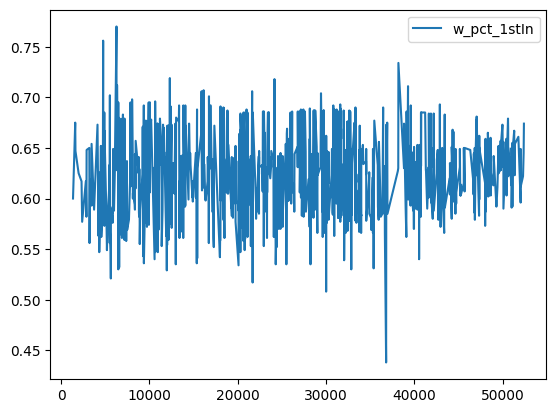

In [69]:
match_df = match_df.to_pandas()
match_df[match_df["w_name"]=="Novak Djokovic"][["w_pct_1stIn"]].plot()

In [ ]:
def get_win_rates(player, games_played, category, values, prefix):
    winrates = {}
    for value in values:

        matches_played = games_played[games_played[category] == value].shape[0]

        matches_won = games_played[(games_played["w_id"] == player) & (games_played[category] == value)].shape[0]

        winrates[f"{prefix}{value} winRt"] = round(matches_won / matches_played, 3) if matches_played > 0 else 0
    return winrates


def calculate_win_rates(row):

    idx = row.name
    prev_matches = match_df.iloc[idx+1:]

    w_matches_played = prev_matches[(prev_matches["w_id"]==row["w_id"]) | \
                                    (prev_matches["l_id"]==row["w_id"])]
    l_matches_played = prev_matches[(prev_matches["w_id"]==row["l_id"]) | \
                                    (prev_matches["l_id"]==row["l_id"])]
    
    surfaces = ["Grass", "Hard", "Clay"]
    tourney_levels = ["G", "A", "M", "F", "O"]

    winRt_dict = {}

    for category, values in zip( ["surface", "tourney_level"], [surfaces, tourney_levels] ):

        winRt_dict.update(
            get_win_rates(row["w_id"], w_matches_played, category=category, values=values, prefix="w_")
        )
        winRt_dict.update(
            get_win_rates(row["l_id"], l_matches_played, category=category, values=values, prefix="l_")
        )

    for key in winRt_dict.keys():
        row[key] = winRt_dict[key]

    return row

match_df = match_df.apply(calculate_win_rates, axis=1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000


In [ ]:
match_df = pd.read_csv("PlayerMatches.csv").drop(columns="Unnamed: 0")
match_df.head()

C:\Users\aurel\AppData\Local\Temp\ipykernel_22732\4217852776.py:1: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  match_df = pd.read_csv("PlayerMatches.csv").drop(columns="Unnamed: 0")


tourney_id tourney_name surface  draw_size tourney_level tourney_date  \
0  2024-7694         Lyon    Clay         32             A   2024-05-20   
1  2024-0322       Geneva    Clay         32             A   2024-05-20   
2  2024-0322       Geneva    Clay         32             A   2024-05-20   
3  2024-0322       Geneva    Clay         32             A   2024-05-20   
4  2024-0322       Geneva    Clay         32             A   2024-05-20   

   match_num  winner_id winner_seed winner_entry       winner_name  \
0        271     126846         NaN          NaN  Aleksandar Vukic   
1        287     202104           5          NaN    Sebastian Baez   
2        273     202104           5          NaN    Sebastian Baez   
3        275     207925         NaN          NaN    Flavio Cobolli   
4        276     200325         NaN          NaN   Emil Ruusuvuori   

  winner_hand  winner_ht winner_ioc  winner_age  loser_id loser_seed  \
0           R      188.0        AUS        28.1    111456        NaN   
1           R      170.0        ARG        23.3    106148        NaN   
2           R      170.0        ARG        23.3    111576        NaN   
3           R        NaN        ITA        22.0    106234        NaN   
4           R      188.0        FIN        25.1    106218        NaN   

  loser_entry               loser_name loser_hand  loser_ht loser_ioc  \
0         NaN       Mackenzie Mcdonald          R     178.0       USA   
1         NaN  Roberto Carballes Baena          R     183.0       ESP   
2         NaN              Sumit Nagal          R     178.0       IND   
3         NaN           Aslan Karatsev          R     185.0       RUS   
4         NaN             Marcos Giron          R     180.0       USA   

   loser_age       score  best_of round  minutes  w_ace  w_df  w_svpt  \
0       29.0     6-2 6-2        3   R32     75.0    8.0   0.0    46.0   
1       31.1     6-3 6-0        3   R16     71.0    1.0   1.0    52.0   
2       26.7  7-6(7) 6-3        3   R32     99.0    2.0   1.0    71.0   
3       30.7     7-5 6-1        3   R32     86.0    5.0   1.0    55.0   
4       30.8     6-3 6-3        3   R32     95.0    3.0   1.0    55.0   

   w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  \
0     25.0      21.0      11.0      8.0        2.0        3.0    1.0   2.0   
1     42.0      29.0       6.0      7.0        6.0        6.0    0.0   1.0   
2     55.0      40.0      10.0     11.0        0.0        1.0    0.0   0.0   
3     32.0      23.0      13.0     10.0        2.0        4.0    0.0   5.0   
4     34.0      22.0      17.0      9.0        3.0        4.0    5.0   3.0   

   l_svpt  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  \
0    56.0     36.0      19.0       6.0      8.0        3.0        8.0   
1    49.0     38.0      19.0       4.0      8.0        4.0        9.0   
2    59.0     43.0      30.0      10.0     10.0        1.0        3.0   
3    73.0     48.0      28.0       7.0      9.0       10.0       15.0   
4    72.0     41.0      26.0      12.0      9.0        7.0       11.0   

   winner_rank  winner_rank_points  loser_rank  loser_rank_points  \
0         93.0               647.0        74.0              735.0   
1         20.0              1985.0        62.0              811.0   
2         20.0              1985.0        94.0              646.0   
3         56.0               860.0        82.0              705.0   
4         66.0               768.0        48.0             1000.0   

   winner_h2h_won  loser_h2h_won  winner_min_rank  loser_min_rank  \
0             0.0            0.0             50.0            37.0   
1             1.0            0.0             19.0            51.0   
2             0.0            0.0             19.0            93.0   
3             0.0            0.0             56.0            14.0   
4             0.0            3.0             38.0            44.0   

   w_1st_RetPtsWon  w_1st_RetPtsPlyd  w_2nd_RetPtsWon  w_2nd_RetPtsPlyd  \
0     

In [ ]:
stats = ['Grass winRt', 'Hard winRt', 'Clay winRt', 'G winRt', 'A winRt', 'M winRt',
         'F winRt', 'O winRt', 'pct_1stIn', 'pct_1stWon', 'pct_2ndWon', 'pct_SvPtsWon', 
         'pct_bpConv', 'pct_bpSaved','pct_1stRetPtsWon', 'pct_2ndRetPtsWon']

# will hold player id anem and all aggregate recent stats
stats_df = pd.DataFrame( columns=["player_id", "name"] + stats )

for i, player_id in enumerate(players["player_id"].unique()):

    """
    Get the most recent match from the player and extract stats from that match,
    those msot recent stats will act as the players current overall statistics
    (for use in dashboard and making future predictions).
    """
    recent_matches = match_df[(match_df["w_id"]==player_id) | \
                              (match_df["l_id"]==player_id)]
    
    """
    Some players in players df did not play in the timeframe we are examining,
    for these players we will set all stats to zero, this will not affect
    our model since these players do not exist in match_df
    """
    if recent_matches.empty:
        # uncomment if you want to include players in players df who are not in match_df
        # stat_dict = {stat:0 for stat in stats}
        # p_name = players[players["player_id"]==player_id]["name"].values[0]
        # stat_dict["name"], stat_dict["player_id"] = p_name, player_id
        # stats_df.loc[len(stats_df)] = stat_dict
        continue
    
    rec_match = recent_matches.iloc[0]

    # find out if most recent match was win or loss
    prefix = "w_" if player_id == rec_match["w_id"] else "l_" 
    p_name = rec_match["w_name"] if prefix == "w_" else rec_match["l_name"]

    stat_dict = {stat: rec_match[prefix+stat] for stat in stats}

    stat_dict["name"], stat_dict["player_id"] = p_name, player_id

    stats_df.loc[len(stats_df)] = stat_dict # append stats dict to stats_df
    
stats_df[stats_df["name"]=="Carlos Alcaraz"]

player_id            name  Grass winRt  Hard winRt  Clay winRt  G winRt  \
1196     207989  Carlos Alcaraz        0.889       0.757       0.805    0.818   

      A winRt  M winRt  F winRt  O winRt  pct_1stIn  pct_1stWon  pct_2ndWon  \
1196    0.786    0.763      0.0      0.0      0.653       0.712       0.556   

      pct_SvPtsWon  pct_bpConv  pct_bpSaved  pct_1stRetPtsWon  \
1196         0.657       0.412        0.636             0.343   

      pct_2ndRetPtsWon  
1196             0.537

In [ ]:
list_of_players = [] # will hold dictionaries of stats for each player, will later become a dataframe

def calculate_win_rates(player, games_played, category, values): #used to calculate winrates for various surfaces and tournament levels
    winrates = {}
    for value in values:
        matches_played = games_played[games_played[category] == value].shape[0]
        matches_won = games_played[(games_played["winner_id"] == player) & (games_played[category] == value)].shape[0]
        winrates[f"{value} winRt"] = round(matches_won / matches_played, 3) if matches_played > 0 else 0
    return winrates

def sum_player_stats(player): #adds the corresponding statistics for when the player lost and when the player won
        
        winner_df = match_df[match_df["winner_id"]==player] #matches where player won
        loser_df = match_df[match_df["loser_id"]==player] #matches where player lost

        stats = ["ace", "df","svpt","1stIn","1stWon","2ndWon","SvGms","bpSaved", "bpFaced", 
                 "1st_RetPtsWon", "2nd_RetPtsWon", "2nd_RetPtsPlyd", "bp_chances", "bp_converted"]

        total_stats = {}
        for stat in stats:

            total_stats[stat] = winner_df[["w_"+stat]].sum().item() + loser_df[["l_"+stat]].sum().item()
            
        return total_stats

player_ids = set(match_df["winner_id"].unique()) | set(match_df["loser_id"].unique()) #gets every unique player ID

for player in player_ids: # iterates through unique player ids

    player_stats = {}   
    
    #finding winrates for each surface type and each tournament level
    
    surfaces = ["Grass", "Hard", "Clay"]
    tourney_levels = ["G", "A", "M", "F", "O"]

    games_played = match_df[(match_df["winner_id"] == player) | (match_df["loser_id"] == player)]
    
    surface_winrates = calculate_win_rates(player, games_played, "surface", surfaces) 
    tourney_level_winrates = calculate_win_rates(player, games_played, "tourney_level", tourney_levels)    

    # extracting name from players dataframe
    name = players[players["player_id"]==player]
    name = name["name"].item()

    
    total_stats = sum_player_stats(player)

    player_stats = {"player_id":player, 
                    "name": name, 
                    "svpts":total_stats["svpt"], # total serve points played
                    "aces":total_stats["ace"], # total aces
                    "df": total_stats["df"], # total double faults
                    "pct_1stIn": round(total_stats["1stIn"]/total_stats["svpt"], 3) if total_stats["svpt"] > 0 else 0, 
                    "pct_1stWon": round(total_stats["1stWon"]/total_stats["1stIn"], 3) if total_stats["1stIn"] > 0 else 0, #% first serve points won
                    "pct_2ndWon" : round(total_stats["2ndWon"]/(total_stats["svpt"]-total_stats["1stIn"]), 3) if (total_stats["svpt"]-total_stats["1stIn"]) > 0 else 0,
                    "pct_SvPtsWon" : round((total_stats["1stWon"]+total_stats["2ndWon"])/total_stats["svpt"],3) if total_stats["svpt"] > 0 else 0,
                    "bp_faced": total_stats["bpFaced"], 
                    "pct_bp_conv": round(total_stats["bp_converted"]/total_stats["bp_chances"],3) if total_stats["bp_chances"] > 0 else 0,
                    "pct_bp_saved" : round(total_stats["bpSaved"]/total_stats["bpFaced"], 3) if total_stats["bpFaced"] > 0 else 0,
                    "pct_1stRetPtsWon" : round(total_stats["1st_RetPtsWon"]/total_stats["1stIn"], 3) if total_stats["1stIn"] > 0 else 0,
                    "pct_2ndRetPtsWon" : round(total_stats["2nd_RetPtsWon"]/total_stats["2nd_RetPtsPlyd"], 3)if total_stats["2nd_RetPtsPlyd"] > 0 else 0
                   }    
        
    player_stats.update(surface_winrates) #adding surface win rates to player stats
    player_stats.update(tourney_level_winrates) #adding tournement level win rates to player stats

    list_of_players.append(player_stats)
    
stats_df = pd.DataFrame(list_of_players)

alcaraz = stats_df[stats_df["name"]=="Carlos Alcaraz"]
print("This matches up almost EXACTLY with his ATP stats online")
alcaraz

KeyError: "None of [Index(['w_bp_chances'], dtype='object')] are in the [columns]"

##### The best way to know if the surface winrates calculations worked is to check the king of clay's (Rafael Nadal) stats on clay 

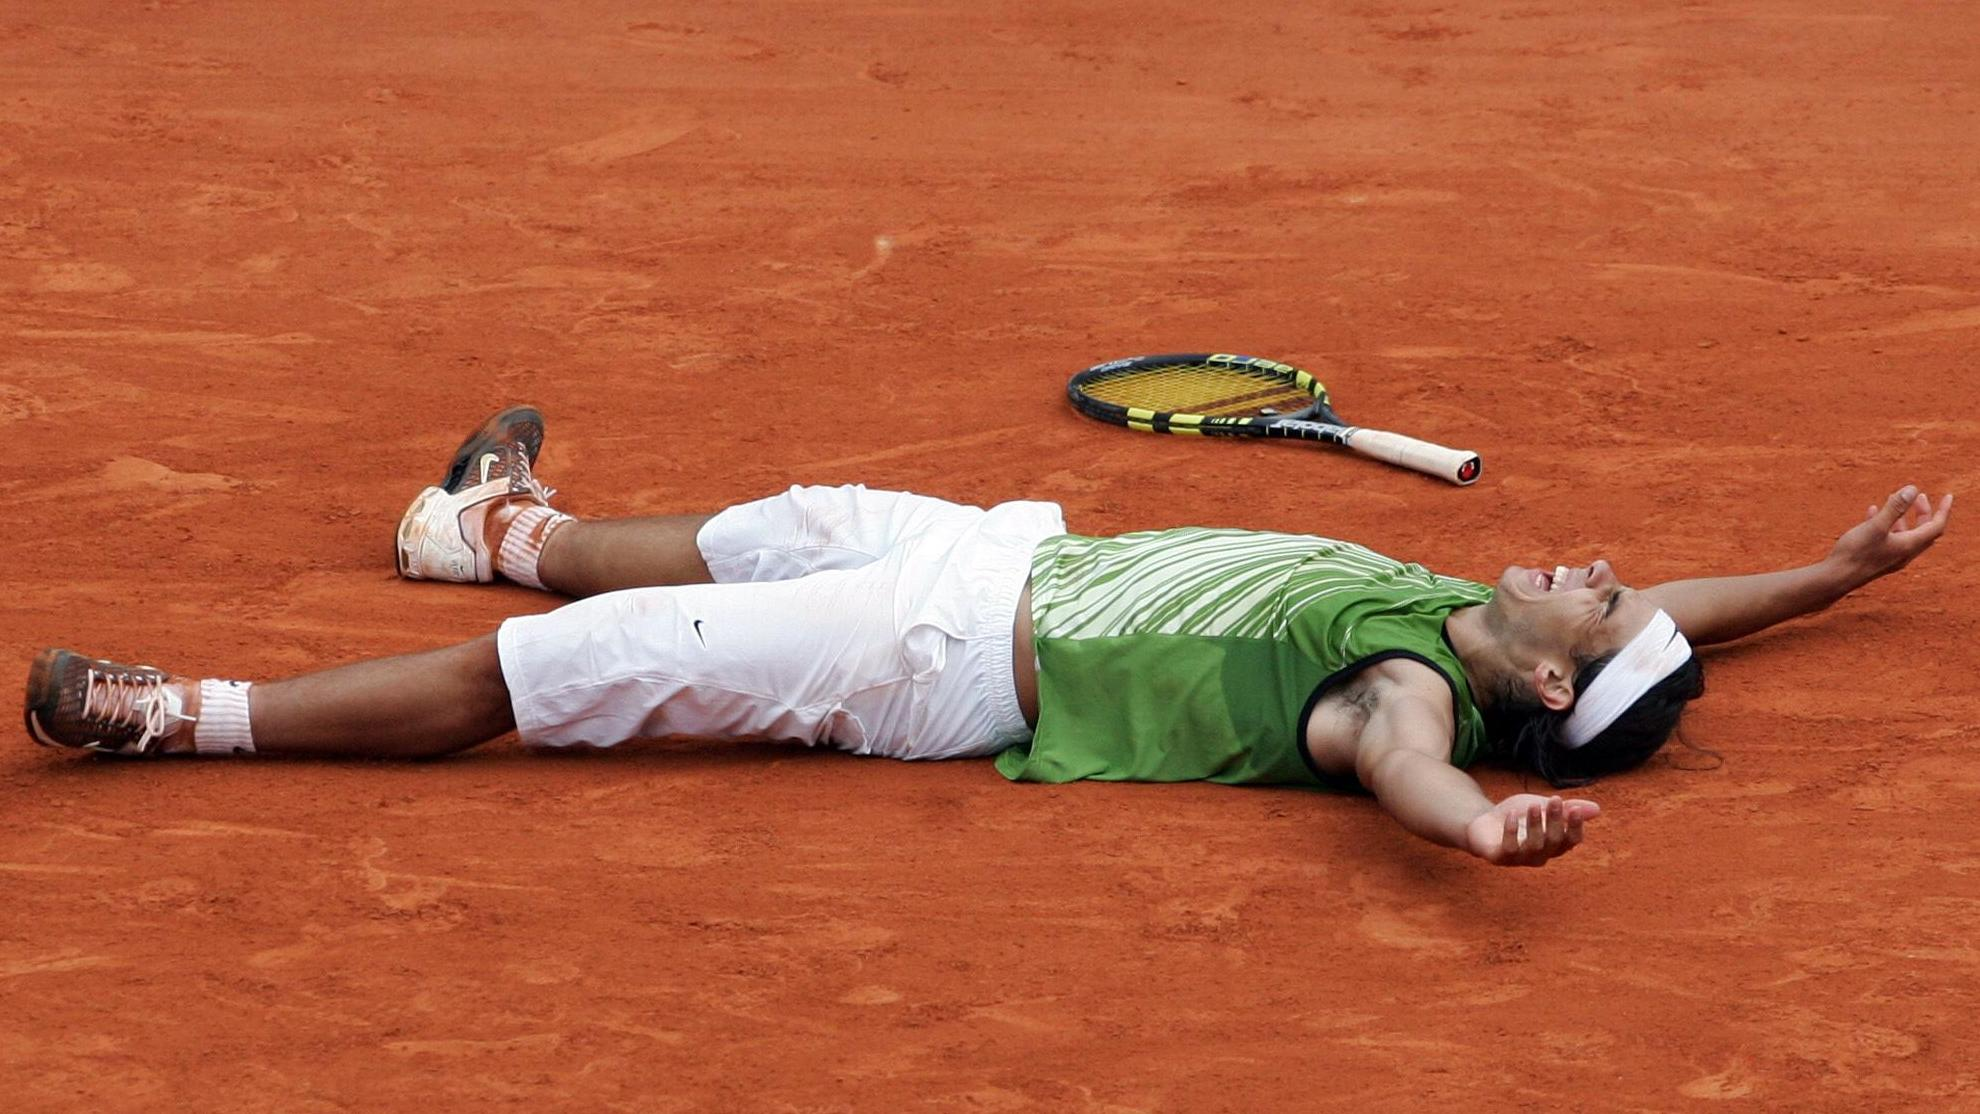

In [ ]:
rafa = stats_df[stats_df["name"]=="Rafael Nadal"]
print("Clay win rate: {}".format(rafa["Clay winRt"].values[0]))
print("...Yeah, that checks out!")

Clay win rate: 0.923
...Yeah, that checks out!


##### We can now get rid of match specific stats, we won't have access to game stats to predict future matches

In [ ]:
match_df = match_df.drop(columns=["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms","w_bpSaved", "w_bpChances",
                                  "w_bpFaced", "w_1st_RetPtsWon", "w_1st_RetPtsPlyd", "w_2nd_RetPtsWon", "w_2nd_RetPtsPlyd",
                                  "l_ace", "l_df","l_svpt","l_1stIn","l_1stWon","l_2ndWon","l_SvGms","l_bpSaved", "w_bpConv",
                                  "l_bpFaced", "l_1st_RetPtsWon", "l_2nd_RetPtsWon", "l_2nd_RetPtsPlyd", "l_bpChances",
                                  "w_rank_points", "l_rank_points", "w_entry", "l_entry", "l_bpConv", "minutes", "w_seed",
                                  "l_seed", "w_entry", "tourney_id", "draw_size","match_num", "best_of", "round"])

### Removing matches where a player retires, as they are almost always due to injuries and do not give insight into the players' actual performance

In [ ]:
old_retired_matches_count = match_df[match_df['score'].str.contains('RET')].shape[0] #get the count before removal

match_df = match_df[~match_df['score'].str.contains('RET')]
retired_matches_count = match_df[match_df['score'].str.contains('RET')].shape[0]

print("# of retired matches before removal: {}".format(old_retired_matches_count))
print("# of retired matches after removal: {}".format(retired_matches_count))

# of retired matches before removal: 1637
# of retired matches after removal: 0


### I want to add another column for the country of the tournament so I can see if one of the players was playing in their home country, which most likely has effects on the outcome of the match.

##### I gave ChatGPT the list of all the unique tournaments and it wrote out the 3 letter country code for each (don't worry, I double checked its output :) )

In [ ]:
tournament_country_codes = {
    "Australian Open": "AUS",
    "Roland Garros": "FRA",
    "Wimbledon": "GBR",
    "Miami Masters": "USA",
    "Indian Wells Masters": "USA",
    "US Open": "USA",
    "Us Open": "USA",
    "Rome Masters": "ITA",
    "Madrid Masters": "ESP",
    "Cincinnati Masters": "USA",
    "Monte Carlo Masters": "MCO",
    "Canada Masters": "CAN",
    "Paris Masters": "FRA",
    "Barcelona": "ESP",
    "Shanghai Masters": "CHN",
    "Washington": "USA",
    "Winston-Salem": "USA",
    "Queen's Club": "GBR",
    "Hamburg": "DEU",
    "Dubai": "ARE",
    "Rotterdam": "NLD",
    "Acapulco": "MEX",
    "Delray Beach": "USA",
    "Doha": "QAT",
    "Buenos Aires": "ARG",
    "Vienna": "AUT",
    "Marseille": "FRA",
    "Halle": "DEU",
    "Munich": "DEU",
    "Montpellier": "FRA",
    "Estoril": "PRT",
    "Newport": "USA",
    "Basel": "CHE",
    "Tokyo": "JPN",
    "Gstaad": "CHE",
    "Stuttgart": "DEU",
    "Atlanta": "USA",
    "Metz": "FRA",
    "Bastad": "SWE",
    "Stockholm": "SWE",
    "Houston": "USA",
    "Auckland": "NZL",
    "Kitzbuhel": "AUT",
    "Umag": "HRV",
    "Beijing": "CHN",
    "s Hertogenbosch": "NLD",
    "Brisbane": "AUS",
    "Eastbourne": "GBR",
    "Moscow": "RUS",
    "Sydney": "AUS",
    "St. Petersburg": "RUS",
    "Santiago": "CHL",
    "Geneva": "CHE",
    "Memphis": "USA",
    "Chennai": "IND",
    "Sao Paulo": "BRA",
    "Sofia": "BGR",
    "Bucharest": "ROU",
    "Antwerp": "BEL",
    "Los Cabos": "MEX",
    "Rio de Janeiro": "BRA",
    "Tour Finals": "GBR",
    "Marrakech": "MAR",
    "Nice": "FRA",
    "Lyon": "FRA",
    "Valencia": "ESP",
    "Zagreb": "HRV",
    "Atp Cup": "AUS",
    "Kuala Lumpur": "MYS",
    "Casablanca": "MAR",
    "Cordoba": "ARG",
    "Chengdu": "CHN",
    "Pune": "IND",
    "Shenzhen": "CHN",
    "Dusseldorf": "DEU",
    "San Jose": "USA",
    "Antalya": "TUR",
    "Bangkok": "THA",
    "Belgrade": "SRB",
    "Quito": "ECU",
    "Istanbul": "TUR",
    "Nottingham": "GBR",
    "NextGen Finals": "ITA",
    "New York": "USA",
    "Budapest": "HUN",
    "Mallorca": "ESP",
    "Los Angeles": "USA",
    "Dallas": "USA",
    "Bogota": "COL",
    "United Cup": "AUS",
    "Rio Olympics": "BRA",
    "Tokyo Olympics": "JPN",
    "London Olympics": "GBR",
    "Johannesburg": "ZAF",
    "Adelaide 1": "AUS",
    "Costa Do Sauipe": "BRA",
    "Astana": "KAZ",
    "Murray River Open": "AUS",
    "Great Ocean Road Open": "AUS",
    "Nur-Sultan": "KAZ",
    "Zhuhai": "CHN",
    "Adelaide": "AUS",
    "Adelaide 2": "AUS",
    "San Diego": "USA",
    "New Haven": "USA",
    "Laver Cup": "VAR",
    "ATP Rio de Janeiro": "BRA",
    "St Petersburg": "RUS",
    "Vina del Mar": "CHL",
    "Cologne 2": "DEU",
    "Belgrade 2": "SRB",
    "Parma": "ITA",
    "Cagliari": "ITA",
    "Marbella": "ESP",
    "Singapore": "SGP",
    "Cologne 1": "DEU",
    "Sardinia": "ITA",
    "Melbourne": "AUS",
    "Tel Aviv": "ISR",
    "Seoul": "KOR",
    "Florence": "ITA",
    "Naples": "ITA",
    "Gijon": "ESP",
    "Banja Luka": "BIH",
    "Hong Kong": "HKG"
}

match_df["tourney_country"] = match_df["tourney_name"].map(tournament_country_codes)
match_df[["tourney_name","tourney_country"]].head(3)

tourney_name tourney_country
0         Lyon             FRA
1       Geneva             CHE
2       Geneva             CHE

##### Defining a function to find out if one, both, or neither of the players are playing in their home country (1 means they are playing in their home country and 0 means the opposite)

In [ ]:
def player_in_home(row):
    winner_at_home = 1 if row["w_ioc"] == row["tourney_country"] else 0
    loser_at_home = 1 if row["l_ioc"] == row["tourney_country"] else 0
    
    return pd.Series([winner_at_home, loser_at_home], index=["w_at_home", "l_at_home"])

match_df[["w_at_home", "l_at_home"]] = match_df.apply(player_in_home, axis=1)

#testing function to see if results are accurate
match_df[(match_df["w_at_home"]==1) & (match_df["l_at_home"]==1)].head(3)

tourney_name surface tourney_level tourney_date    w_id  \
31           Lyon    Clay             A   2024-05-20  124186   
47           Lyon    Clay             A   2024-05-20  208659   
146  Rome Masters    Clay             M   2024-05-06  209263   

                         w_name w_hand   w_ht w_ioc  w_age    l_id  \
31             Alexandre Muller      R  183.0   FRA   27.2  104755   
47   Giovanni Mpetshi Perricard      R    NaN   FRA   20.8  200384   
146              Matteo Gigante      L    NaN   ITA   22.3  206748   

              l_name l_hand   l_ht l_ioc  l_age        score  w_rank  l_rank  \
31   Richard Gasquet      R  185.0   FRA   37.9      6-4 6-4    90.0   124.0   
47       Hugo Gaston      L  173.0   FRA   23.6  6-4 4-6 6-3   117.0   104.0   
146  Giulio Zeppieri      L  185.0   ITA   22.4   7-6(2) 6-4   139.0   144.0   

     w_h2h_won  l_h2h_won  w_min_rank  l_min_rank  l_1st_RetPtsPlyd  \
31         1.0        0.0        71.0         7.0              39.0   
47         0.0        0.0       117.0        58.0              59.0   
146        0.0        0.0         NaN       111.0              50.0   

     w_pct_1stIn  w_pct_1stWon  w_pct_2ndWon  w_pct_SvPtsWon  w_pct_bpConv  \
31         0.637         0.654         0.504           0.600         0.417   
47         0.632         0.762         0.503           0.667         0.320   
146        0.474         0.667         0.250           0.447         0.000   

     w_pct_bpSaved  w_pct_1stRetPtsWon  w_pct_2ndRetPtsWon  l_pct_1stIn  \
31           0.556               0.291               0.502        0.615   
47           0.636               0.232               0.437        0.563   
146          0.667               0.143               0.273        0.610   

     l_pct_1stWon  l_pct_2ndWon  l_pct_SvPtsWon  l_pct_bpConv  l_pct_bpSaved  \
31          0.729         0.532           0.653         0.405          0.612   
47          0.652         0.486           0.579         0.384          0.612   
146         0.721         0.513           0.640         0.333          0.598   

     l_pct_1stRetPtsWon  l_pct_2ndRetPtsWon  w_Grass winRt  w_Hard winRt  \
31                0.300               0.507            0.5         0.333   
47                0.306               0.484            0.0         0.667   
146               0.266               0.457            0.0         0.000   

     w_Clay winRt  l_Grass winRt  l_Hard winRt  l_Clay winRt  w_G winRt  \
31          0.429          0.664         0.599         0.618      0.222   
47          0.500          0.600         0.342         0.400      0.000   
146         0.000          0.000         0.200         0.364      0.000   

     w_A winRt  w_M winRt  w_F winRt  w_O winRt  l_G winRt  l_A winRt  \
31       0.407      0.455        0.0        0.0      0.632      0.645   
47       0.600      0.000        0.0        0.0      0.385      0.333   
146      0.000      0.000        0.0        0.0      0.400      0.333   

     l_M winRt  l_F winRt  l_O winRt tourney_country  w_at_home  l_at_home  
31       0.547      0.167        0.5             FRA          1          1  
47       0.538      0.000        0.0             FRA          1          1  
146      0.000      0.000        0.0             ITA          1          1

##### Now that we know if a player is playing in their home country, some of the columns are no longer necessary. Eliminating unnecesary columns saves space and processing power

In [ ]:
match_df = match_df.drop(columns=["tourney_name", "w_ioc", "tourney_country", "l_ioc"])

### A player's overall win % would certainly help train our predictive model, but what if we could make it even more powerful for predicting?
#### After training the models initially, I came across a blog of someone who made a very similar model to me (https://nycdatascience.com/blog/student-works/utilizing-data-to-predict-winners-of-tennis-matches/)

#### They suggested using a "recent performance" metric which is calculated as follows:

#### 

$$
\text{Overall Win \%} + \log_{10}\left(1 - \text{Overall Win \%} + \text{Last 6 Months Win \%}\right)
$$

$$
\text{Where the log expression is a "penalty"}
$$

In [ ]:
match_df["tourney_date"] = pd.to_datetime(match_df["tourney_date"])

def calculate_recent_performance(player_id, current_date, months_to_consider=6):
    """Calculate recent performance score for a given player."""
    
    x_months_ago = current_date - timedelta(days=months_to_consider * 30)
    
    # get all past matches where player won or lost
    player_matches = match_df[
        (match_df["tourney_date"] < current_date) & 
        ((match_df["w_id"] == player_id) | (match_df["l_id"] == player_id))
    ]
    
    total_matches = len(player_matches) # no. matches played
    if total_matches == 0:
        return 0  # player has no previous matches played

    total_wins = (player_matches["w_id"] == player_id).sum()
    overall_win_rate = total_wins / total_matches

    # recent matches within months_to_consider time frame
    recent_matches = player_matches[player_matches["tourney_date"] >= x_months_ago]

    recent_total = len(recent_matches)
    recent_win_rate = (recent_matches["w_id"] == player_id).sum() / recent_total \
                      if recent_total > 0 else 0 # no recent matches played

    return overall_win_rate + math.log10(1 - overall_win_rate + recent_win_rate) \
        if (1 - overall_win_rate + recent_win_rate) > 0 else 0

def recent_performance(row, months_to_consider=6):
    """calculate recent performance metric for winner and loser of each match."""
    
    current_date = pd.to_datetime(row["tourney_date"])
    
    row["w_recPerf"] = calculate_recent_performance(row["w_id"], current_date, months_to_consider)
    row["l_recPerf"] = calculate_recent_performance(row["l_id"], current_date, months_to_consider)
    
    return row


match_df = match_df.apply(recent_performance, axis=1)
match_df.head(3)

surface tourney_level tourney_date    w_id            w_name w_hand   w_ht  \
0    Clay             A   2024-05-20  126846  Aleksandar Vukic      R  188.0   
1    Clay             A   2024-05-20  202104    Sebastian Baez      R  170.0   
2    Clay             A   2024-05-20  202104    Sebastian Baez      R  170.0   

   w_age    l_id                   l_name l_hand   l_ht  l_age       score  \
0   28.1  111456       Mackenzie Mcdonald      R  178.0   29.0     6-2 6-2   
1   23.3  106148  Roberto Carballes Baena      R  183.0   31.1     6-3 6-0   
2   23.3  111576              Sumit Nagal      R  178.0   26.7  7-6(7) 6-3   

   w_rank  l_rank  w_h2h_won  l_h2h_won  w_min_rank  l_min_rank  \
0    93.0    74.0        0.0        0.0        50.0        37.0   
1    20.0    62.0        1.0        0.0        19.0        51.0   
2    20.0    94.0        0.0        0.0        19.0        93.0   

   l_1st_RetPtsPlyd  w_pct_1stIn  w_pct_1stWon  w_pct_2ndWon  w_pct_SvPtsWon  \
0              25.0        0.595         0.729         0.513           0.641   
1              42.0        0.721         0.643         0.529           0.611   
2              55.0        0.721         0.643         0.528           0.611   

   w_pct_bpConv  w_pct_bpSaved  w_pct_1stRetPtsWon  w_pct_2ndRetPtsWon  \
0         0.344          0.593               0.255               0.457   
1         0.410          0.589               0.326               0.518   
2         0.409          0.590               0.326               0.518   

   l_pct_1stIn  l_pct_1stWon  l_pct_2ndWon  l_pct_SvPtsWon  l_pct_bpConv  \
0        0.641         0.692         0.506           0.625         0.397   
1        0.630         0.669         0.503           0.608         0.431   
2        0.699         0.606         0.548           0.588         0.388   

   l_pct_bpSaved  l_pct_1stRetPtsWon  l_pct_2ndRetPtsWon  w_Grass winRt  \
0          0.604               0.287               0.509          0.333   
1          0.585               0.296               0.507          0.429   
2          0.591               0.267               0.503          0.429   

   w_Hard winRt  w_Clay winRt  l_Grass winRt  l_Hard winRt  l_Clay winRt  \
0         0.396         0.300          0.519         0.490         0.280   
1         0.360         0.633          0.214         0.367         0.500   
2         0.360         0.629          0.000         0.182         0.364   

   w_G winRt  w_A winRt  w_M winRt  w_F winRt  w_O winRt  l_G winRt  \
0      0.250      0.400      0.375        0.0        0.0      0.472   
1      0.438      0.602      0.321        0.0        0.0      0.300   
2      0.438      0.598      0.321        0.0        0.0      0.250   

   l_A winRt  l_M winRt  l_F winRt  l_O winRt  w_at_home  l_at_home  \
0      0.479      0.435        0.0        0.0          0          0   
1      0.488      0.379        0.0        0.0          0          0   
2      0.231      0.333        0.0        0.5          0          0   

   w_recPerf  l_recPerf  
0   0.341502   0.192769  
1   0.571134   0.453848  
2   0.571134   0.315016

### So that we are able to have information about recent player performance when interactive web app is made, we need to add every player's most recent performance metric to stats_df

In [ ]:
def add_recPerf(row): 
    player_id = row["player_id"]

    # Find the player's most recent match
    recent_match = match_df[(match_df["w_id"] == player_id) | (match_df["l_id"] == player_id)].head(1)
    
    if not recent_match.empty:  # Check if a recent match was found
        if recent_match.iloc[0]["w_id"] == player_id:  # If they were the winner, get the winner's recent performance
            row["recPerf"] = recent_match.iloc[0]["w_recPerf"]
        else:  # Else, get the loser's recent performance
            row["recPerf"] = recent_match.iloc[0]["l_recPerf"]
    else:
        row["recPerf"] = np.nan  # Or handle the case where no match is found

    return row

stats_df = stats_df.apply(add_recPerf, axis=1)

In [ ]:
stats_df["recPerf"].head(5).values

array([0.69474921, 0.        , 0.60658618, 0.14368613, 0.65590726])

### The existence of columns for the winner stats will perpetuate ***bias*** within the classifier, as it will quickly learn to weight the winner statistics more than the loser statistics. To counter this and prep the data for training, we need to get rid of the ***winner/loser*** schema and instead implement a ***player1, player2*** schema and randomly decide if player1 or player2 will inherit the winner stats for each row (the other player will inherit the loser stats). In the winner column, 1 designates that player1 won and a 0 designates that player2 won.

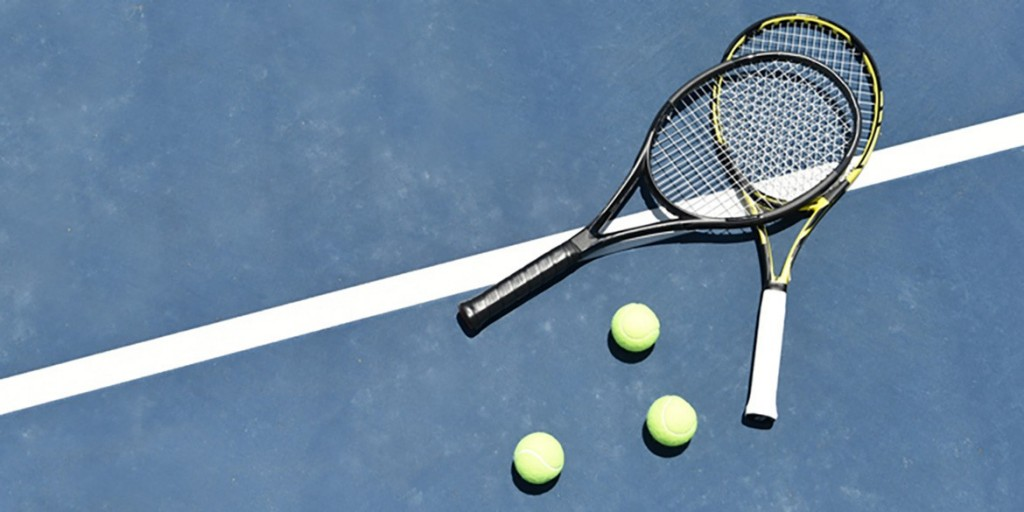


In [ ]:
def transform_row(row):
    # p1 is selected to be the winner if the random number is >0.5
    w_prefix, l_prefix = ('w_', 'l_') if np.random.rand() > 0.5 else ('l_', 'w_')
    
    transformed_row = {
        'surface': row['surface'],
        'tourney_level': row['tourney_level'],
        'tourney_date': row['tourney_date'],
        'p1_id': row[f'{w_prefix}id'],
        'p1_name': row[f'{w_prefix}name'],
        'p1_age': row[f"{w_prefix}age"],
        'p1_ht' : row[f'{w_prefix}ht'],
        'p1_hand': row[f'{w_prefix}hand'],
        'p1_atHome': row[f'{w_prefix}at_home'],
        'p1_rank': row[f'{w_prefix}rank'],
        'p1_min_rank': row[f'{w_prefix}min_rank'],
        'p1_h2h_won': row[f'{w_prefix}h2h_won'],
        'p1_pct_1stIn': row[f'{w_prefix}pct_1stIn'],
        'p1_pct_1stWon': row[f'{w_prefix}pct_1stWon'],
        'p1_pct_2ndWon': row[f'{w_prefix}pct_2ndWon'],
        'p1_pct_SvPtsWon': row[f'{w_prefix}pct_SvPtsWon'],
        'p1_pct_bpConv': row[f'{w_prefix}pct_bpConv'],
        'p1_pct_bpSaved': row[f'{w_prefix}pct_bpSaved'],
        'p1_pct_1stRetPtsWon': row[f'{w_prefix}pct_1stRetPtsWon'],
        'p1_pct_2ndRetPtsWon': row[f'{w_prefix}pct_2ndRetPtsWon'],
        'p1_Grass winRt': row[f'{w_prefix}Grass winRt'],
        'p1_Clay winRt': row[f'{w_prefix}Clay winRt'],
        'p1_Hard winRt': row[f'{w_prefix}Hard winRt'],
        'p1_G winRt': row[f'{w_prefix}G winRt'],
        'p1_A winRt': row[f'{w_prefix}A winRt'],
        'p1_M winRt': row[f'{w_prefix}M winRt'],
        'p1_F winRt': row[f'{w_prefix}F winRt'],
        'p1_O winRt': row[f'{w_prefix}O winRt'],
        'p1_recPerf': row[f'{w_prefix}recPerf'],
        'p2_id': row[f'{l_prefix}id'],
        'p2_name': row[f'{l_prefix}name'],
        'p2_age': row[f"{l_prefix}age"],
        'p2_ht' : row[f'{l_prefix}ht'],
        'p2_hand': row[f'{l_prefix}hand'],
        'p2_atHome': row[f'{l_prefix}at_home'],
        'p2_rank': row[f'{l_prefix}rank'],
        'p2_min_rank': row[f'{l_prefix}min_rank'],
        'p2_h2h_won': row[f'{l_prefix}h2h_won'],
        'p2_pct_1stIn': row[f'{l_prefix}pct_1stIn'],
        'p2_pct_1stWon': row[f'{l_prefix}pct_1stWon'],
        'p2_pct_2ndWon': row[f'{l_prefix}pct_2ndWon'],
        'p2_pct_SvPtsWon': row[f'{l_prefix}pct_SvPtsWon'],
        'p2_pct_bpConv': row[f'{l_prefix}pct_bpConv'],
        'p2_pct_bpSaved': row[f'{l_prefix}pct_bpSaved'],
        'p2_pct_1stRetPtsWon': row[f'{l_prefix}pct_1stRetPtsWon'],
        'p2_pct_2ndRetPtsWon': row[f'{l_prefix}pct_2ndRetPtsWon'],
        'p2_Grass winRt': row[f'{l_prefix}Grass winRt'],
        'p2_Clay winRt': row[f'{l_prefix}Clay winRt'],
        'p2_Hard winRt': row[f'{l_prefix}Hard winRt'],
        'p2_G winRt': row[f'{l_prefix}G winRt'],
        'p2_A winRt': row[f'{l_prefix}A winRt'],
        'p2_M winRt': row[f'{l_prefix}M winRt'],
        'p2_F winRt': row[f'{l_prefix}F winRt'],
        'p2_O winRt': row[f'{l_prefix}O winRt'],
        'p2_recPerf': row[f'{l_prefix}recPerf'],
        'winner': 1 if w_prefix=="w_" else 0 # 1 signifies p1 won
    }
    
    return pd.Series(transformed_row)

match_df = match_df.apply(transform_row, axis=1)

match_df.head(2)

surface tourney_level tourney_date   p1_id                  p1_name  p1_age  \
0    Clay             A   2024-05-20  111456       Mackenzie Mcdonald    29.0   
1    Clay             A   2024-05-20  106148  Roberto Carballes Baena    31.1   

   p1_ht p1_hand  p1_atHome  p1_rank  p1_min_rank  p1_h2h_won  p1_pct_1stIn  \
0  178.0       R          0     74.0         37.0         0.0         0.641   
1  183.0       R          0     62.0         51.0         0.0         0.630   

   p1_pct_1stWon  p1_pct_2ndWon  p1_pct_SvPtsWon  p1_pct_bpConv  \
0          0.692          0.506            0.625          0.397   
1          0.669          0.503            0.608          0.431   

   p1_pct_bpSaved  p1_pct_1stRetPtsWon  p1_pct_2ndRetPtsWon  p1_Grass winRt  \
0           0.604                0.287                0.509           0.519   
1           0.585                0.296                0.507           0.214   

   p1_Clay winRt  p1_Hard winRt  p1_G winRt  p1_A winRt  p1_M winRt  \
0           0.28          0.490       0.472       0.479       0.435   
1           0.50          0.367       0.300       0.488       0.379   

   p1_F winRt  p1_O winRt  p1_recPerf   p2_id           p2_name  p2_age  \
0         0.0         0.0    0.192769  126846  Aleksandar Vukic    28.1   
1         0.0         0.0    0.453848  202104    Sebastian Baez    23.3   

   p2_ht p2_hand  p2_atHome  p2_rank  p2_min_rank  p2_h2h_won  p2_pct_1stIn  \
0  188.0       R          0     93.0         50.0         0.0         0.595   
1  170.0       R          0     20.0         19.0         1.0         0.721   

   p2_pct_1stWon  p2_pct_2ndWon  p2_pct_SvPtsWon  p2_pct_bpConv  \
0          0.729          0.513            0.641          0.344   
1          0.643          0.529            0.611          0.410   

   p2_pct_bpSaved  p2_pct_1stRetPtsWon  p2_pct_2ndRetPtsWon  p2_Grass winRt  \
0           0.593                0.255                0.457           0.333   
1           0.589                0.326                0.518           0.429   

   p2_Clay winRt  p2_Hard winRt  p2_G winRt  p2_A winRt  p2_M winRt  \
0          0.300          0.396       0.250       0.400       0.375   
1          0.633          0.360       0.438       0.602       0.321   

   p2_F winRt  p2_O winRt  p2_recPerf  winner  
0         0.0         0.0    0.341502       0  
1         0.0         0.0    0.571134       0

### Currently, we have a stats_df with aggregate statistics for each player & a dataframe of matches, "match_df". 

#### To train a model to make predictions on future matches, we need the aggregate statistics for each player to be within match_df. This ensures the model can learn which statistics are the most powerful in picking a winner. We will use the .merge() method in pandas to join the stats_df to the match_df where player IDs match. We will then appropriately rename the stats.

In [ ]:
match_df = match_df.drop(columns=["p1_name","p2_name"])

# merge player1 stats with match_df
games_with_p1_stats = match_df.merge(
    stats_df, left_on='p1_id', right_on='player_id', suffixes=('', '_p1')
).drop(columns=['player_id'])

# Rename columns from stats_df to reflect that they are player1's stats
games_with_p1_stats = games_with_p1_stats.rename(columns={
    col: f'p1_{col}' for col in stats_df.columns if col != 'player_id'
})

# Merge player2 stats with the result of the previous merge
games_with_both_stats = games_with_p1_stats.merge(
    stats_df, left_on='p2_id', right_on='player_id', suffixes=('', '_p2')
).drop(columns=['player_id'])

# Rename columns from stats_df to reflect that they are player2's stats
match_df = games_with_both_stats.rename(columns={
    col: f'p2_{col}' for col in stats_df.columns if col != 'player_id'
})

# get rid of any duplicated columns from join
match_df = match_df.loc[:, ~match_df.columns.duplicated()]

match_df.head(2)

surface tourney_level   p1_id  p1_age  p1_ht p1_hand  p1_atHome  p1_rank  \
0    Clay             A  111456    29.0  178.0       R          0     74.0   
1    Clay             A  124116    28.0  191.0       R          0     45.0   

   p1_recPerf  p1_h2h_wins   p2_id  p2_age  p2_ht p2_hand  p2_atHome  p2_rank  \
0    0.192769          0.0  126846    28.1  188.0       R          0     93.0   
1    0.401692          0.0  134770    25.4  183.0       R          0      7.0   

   p2_recPerf  p2_h2h_wins  winner             p1_name  p1_svpts  p1_aces  \
0    0.341502          0.0       0  Mackenzie Mcdonald   16185.0   1017.0   
1    0.703052          1.0       0     Sebastian Ofner    5905.0    490.0   

   p1_df  p1_pct_1stIn  p1_pct_1stWon  p1_pct_2ndWon  p1_pct_SvPtsWon  \
0  499.0         0.641          0.691          0.505            0.624   
1  205.0         0.567          0.732          0.485            0.625   

   p1_bp_faced  p1_pct_bp_conv  p1_pct_bp_saved  p1_pct_1stRetPtsWon  \
0       1438.0           0.397            0.603                0.279   
1        544.0           0.402            0.614                0.284   

   p1_pct_2ndRetPtsWon  p1_Grass winRt  p1_Hard winRt  p1_Clay winRt  \
0                0.509           0.519           0.49          0.269   
1                0.485           0.429           0.50          0.412   

   p1_G winRt  p1_A winRt  p1_M winRt  p1_F winRt  p1_O winRt  \
0       0.472       0.475       0.435         0.0         0.0   
1       0.500       0.460       0.333         0.0         0.0   

            p2_name  p2_svpts  p2_aces  p2_df  p2_pct_1stIn  p2_pct_1stWon  \
0  Aleksandar Vukic    5374.0    545.0  122.0         0.595          0.730   
1       Casper Ruud   23710.0   1568.0  703.0         0.646          0.724   

   p2_pct_2ndWon  p2_pct_SvPtsWon  p2_bp_faced  p2_pct_bp_conv  \
0          0.513            0.642        428.0           0.351   
1          0.542            0.660       1709.0           0.408   

   p2_pct_bp_saved  p2_pct_1stRetPtsWon  p2_pct_2ndRetPtsWon  p2_Grass winRt  \
0            0.593                0.265                0.460           0.333   
1            0.635                0.280                0.509           0.400   

   p2_Hard winRt  p2_Clay winRt  p2_G winRt  p2_A winRt  p2_M winRt  \
0          0.396          0.364       0.250       0.415       0.375   
1          0.579          0.736       0.654       0.691       0.609   

   p2_F winRt  p2_O winRt  
0         0.0         0.0  
1         0.5         0.0

### We are only interested in the win rates for both players of the surface that is being played on, the model may get distracted by including other win rates. We will only include the win rate for the surface being played on in each match   ദ്ദി(˵ •̀ ᴗ - ˵ )

In [ ]:
def match_surface_stats(row):

    p1_surface_rates = ['p1_Grass winRt', 'p1_Hard winRt', 'p1_Clay winRt'] 
    p2_surface_rates = ['p2_Grass winRt', 'p2_Hard winRt', 'p2_Clay winRt']

    for p1_col, p2_col in zip(p1_surface_rates, p2_surface_rates):
    
        #the third element of column names determines what surface it is (ie: 'G'/'H'/'C')
        if str(row["surface"])[0] == p1_col[3]: 

            row["p1_surface_wRate"] = row[p1_col] #this column will store winrate for surface being played on
            row["p2_surface_wRate"] = row[p2_col]
            break

    return row

match_df = match_df.apply(match_surface_stats, axis=1)
match_df = match_df.drop(columns=['p1_Grass winRt', 'p1_Hard winRt', 'p1_Clay winRt', 
                                  'p2_Grass winRt', 'p2_Hard winRt', 'p2_Clay winRt'])

match_df[["p1_surface_wRate", "p2_surface_wRate"]].head(2)

p1_surface_wRate  p2_surface_wRate
0              0.28             0.300
1              0.50             0.633

### I think it would also prove beneficial to know how a player performs at the tournament level they are playing in. Some players are known to perform better at larger events and some players tend to perform better at smaller events. 

### Let's include the win rate for both players at the tournament level they are currently playing at!

In [ ]:
def tourney_level_stats(row):

    p1_tourney_rates = ['p1_G winRt', 'p1_A winRt', 'p1_M winRt', 'p1_F winRt', 'p1_O winRt'] 
    p2_tourney_rates = ['p2_G winRt', 'p2_A winRt', 'p2_M winRt', 'p2_F winRt', 'p2_O winRt'] 
    
    for p1_col, p2_col in zip(p1_tourney_rates, p2_tourney_rates):
    
        #the third character of column name determines what tourn. level it is (ie: 'A'/'M'/'G')
        if str(row["tourney_level"])[0] == p1_col[3]: 
            row["p1_tourney_wRate"] = row[p1_col] 
            row["p2_tourney_wRate"] = row[p2_col]
            break
    return row

match_df = match_df.apply(tourney_level_stats, axis=1)
match_df = match_df.drop(columns=['p1_G winRt', 'p1_A winRt', 'p1_M winRt', 'p1_F winRt', 'p1_O winRt', 
                                  'p2_G winRt', 'p2_A winRt', 'p2_M winRt', 'p2_F winRt', 'p2_O winRt'])

match_df[["p1_tourney_wRate", "p2_tourney_wRate"]].head(2)

p1_tourney_wRate  p2_tourney_wRate
0             0.479             0.400
1             0.488             0.602

##### One hot encoding left and right handedness with binary values, as they are easier to work with in machine learning algorithms

In [ ]:
# right handedness will correspond to value of 1, 0 for left handedness
match_df['p1_hand_encoded'] = match_df['p1_hand'].apply(lambda x: 1 if x == 'R' else 0)
match_df['p2_hand_encoded'] = match_df['p2_hand'].apply(lambda x: 1 if x == 'R' else 0)
match_df = match_df.drop(columns=["p1_hand", "p2_hand"]) # columns no longer needed

In [ ]:
match_df2 = match_df.copy()
match_df3 = match_df.copy()
match_df4 = match_df.copy()

In [ ]:
# rearranging match_df for convenience and clarity
match_df = match_df[[
    # tournament metadata
    'surface', 'tourney_level', 'tourney_date',
    # player information
    'p1_id', 'p1_name', 'p2_id', 'p2_name', 'p1_age', 'p2_age', 
    'p1_ht', 'p2_ht','p1_hand_encoded', 'p2_hand_encoded',
    'p1_atHome', 'p2_atHome','p1_rank', 'p2_rank', 'p1_min_rank', 'p2_min_rank',
    # general player stats
    'p1_pct_1stIn', 'p2_pct_1stIn','p1_pct_1stWon', 'p2_pct_1stWon',
    'p1_pct_2ndWon', 'p2_pct_2ndWon','p1_pct_SvPtsWon', 'p2_pct_SvPtsWon',
    'p1_pct_bpConv', 'p2_pct_bpConv','p1_pct_bpSaved', 'p2_pct_bpSaved',
    'p1_pct_1stRetPtsWon', 'p2_pct_1stRetPtsWon','p1_pct_2ndRetPtsWon', 'p2_pct_2ndRetPtsWon',
    # player win rates
    'p1_h2h_won', 'p2_h2h_won','p1_recPerf', 'p2_recPerf',
    'p1_surface_wRate', 'p2_surface_wRate','p1_tourney_wRate', 'p2_tourney_wRate',
    
    'winner'
]]

match_df.head(2)

surface tourney_level tourney_date   p1_id                  p1_name   p2_id  \
0    Clay             A   2024-05-20  111456       Mackenzie Mcdonald  126846   
1    Clay             A   2024-05-20  106148  Roberto Carballes Baena  202104   

            p2_name  p1_age  p2_age  p1_ht  p2_ht  p1_hand_encoded  \
0  Aleksandar Vukic    29.0    28.1  178.0  188.0                1   
1    Sebastian Baez    31.1    23.3  183.0  170.0                1   

   p2_hand_encoded  p1_atHome  p2_atHome  p1_rank  p2_rank  p1_min_rank  \
0                1          0          0     74.0     93.0         37.0   
1                1          0          0     62.0     20.0         51.0   

   p2_min_rank  p1_pct_1stIn  p2_pct_1stIn  p1_pct_1stWon  p2_pct_1stWon  \
0         50.0         0.641         0.595          0.692          0.729   
1         19.0         0.630         0.721          0.669          0.643   

   p1_pct_2ndWon  p2_pct_2ndWon  p1_pct_SvPtsWon  p2_pct_SvPtsWon  \
0          0.506          0.513            0.625            0.641   
1          0.503          0.529            0.608            0.611   

   p1_pct_bpConv  p2_pct_bpConv  p1_pct_bpSaved  p2_pct_bpSaved  \
0          0.397          0.344           0.604           0.593   
1          0.431          0.410           0.585           0.589   

   p1_pct_1stRetPtsWon  p2_pct_1stRetPtsWon  p1_pct_2ndRetPtsWon  \
0                0.287                0.255                0.509   
1                0.296                0.326                0.507   

   p2_pct_2ndRetPtsWon  p1_h2h_won  p2_h2h_won  p1_recPerf  p2_recPerf  \
0                0.457         0.0         0.0    0.192769    0.341502   
1                0.518         0.0         1.0    0.453848    0.571134   

   p1_surface_wRate  p2_surface_wRate  p1_tourney_wRate  p2_tourney_wRate  \
0              0.28             0.300             0.479             0.400   
1              0.50             0.633             0.488             0.602   

   winner  
0       0  
1       0

## Removing/Imputing Null Values:

#### Null values can affect the performance of our models. So we need to find out how many null values there are and then decide wether to remove them or impute them using mean, mode, median, etc

In [ ]:
# display columns with null values
null_counts = match_df.isnull().sum()
null_counts[null_counts>0]

p1_age            1
p2_age            1
p1_ht           566
p2_ht           552
p1_rank          65
p2_rank          78
p1_min_rank    1675
p2_min_rank    1648
p1_h2h_won        1
p2_h2h_won        1
dtype: int64

#### Because there is so little missing values for player ranks and age (less than 0.2% of the entries are missing player ranks), I believe it will not hurt our model to drop these values from our match_df

In [ ]:
#drop columns
match_df = match_df.dropna(subset=[
    "p1_age", "p2_age", "p1_rank", "p2_rank", 
    "p1_h2h_won", "p2_h2h_won","p1_min_rank", "p2_min_rank"
    ]
)

#print remaining null columns
null_counts = match_df.isnull().sum()
null_counts[null_counts>0]
print("Size of match_df after removing nulls:", len(match_df))

Size of match_df after removing nulls: 48153


#### Veryfiying normality of player heights to decide if player heights should be imputed by the mean or the median

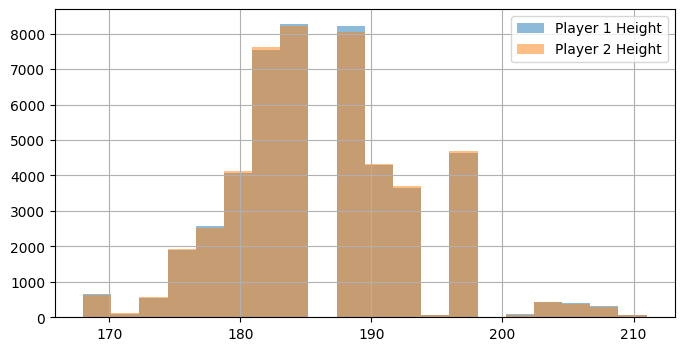

In [ ]:
plt.figure(figsize=(8, 4))

match_df['p1_ht'].hist(bins=20, alpha=0.5, label='Player 1 Height')
match_df['p2_ht'].hist(bins=20, alpha=0.5, label='Player 2 Height')

plt.legend()
plt.show()

In [ ]:
# I chose to impute values with the mean due to the approximate normality of the graph

imputer = SimpleImputer(strategy='mean')

# Fit and transform the selected columns
match_df[["p1_ht", "p2_ht"]] = imputer.fit_transform(match_df[["p1_ht", "p2_ht"]])

# print remaining null columns (should be none)
null_counts = match_df.isnull().sum()
null_counts[null_counts>0]

Series([], dtype: int64)

## Baseline Prediction

### For our classifier models to be worth anything, they must be more accurate than simply picking the higher seeded player to win each time. That is, the models must be able to sometimes predict upsets

In [ ]:
p1_rank = match_df['p1_rank']
p2_rank = match_df['p2_rank']
actual_winner = match_df['winner']

# Create baseline predictions: predict the player with the higher rank (higher rank = lower rank number) as the winner
baseline_predictions = [
    1 if player1 < player2 else 0 for player1, player2 in zip(p1_rank, p2_rank)
]

# Compare baseline predictions with actual winners
accuracy = accuracy_score(actual_winner, baseline_predictions)
print("Baseline accuracy: {}%".format(round(accuracy,4)*100))

Baseline accuracy: 65.28%


##### So any score above this baseline accuracy means our model adds value

In [ ]:
match_df2 = match_df.copy()
match_df3 = match_df.copy()
match_df4 = match_df.copy()

In [ ]:
# making copy of match_df with only numerical values to use for training model
match_df_num = match_df[[
    # player information
    'p1_age', 'p2_age', 'p1_ht', 'p2_ht','p1_hand_encoded', 'p2_hand_encoded',
    'p1_atHome', 'p2_atHome','p1_rank', 'p2_rank', 'p1_min_rank', 'p2_min_rank',
    # general player stats
    'p1_pct_1stIn', 'p2_pct_1stIn','p1_pct_1stWon', 'p2_pct_1stWon',
    'p1_pct_2ndWon', 'p2_pct_2ndWon','p1_pct_SvPtsWon', 'p2_pct_SvPtsWon',
    'p1_pct_bpConv', 'p2_pct_bpConv','p1_pct_bpSaved', 'p2_pct_bpSaved',
    'p1_pct_1stRetPtsWon', 'p2_pct_1stRetPtsWon','p1_pct_2ndRetPtsWon', 'p2_pct_2ndRetPtsWon',
    # player win rates
    'p1_h2h_won', 'p2_h2h_won','p1_recPerf', 'p2_recPerf',
    'p1_surface_wRate', 'p2_surface_wRate','p1_tourney_wRate', 'p2_tourney_wRate',

    'winner'
]]

In [ ]:
good_stats = match_df[(match_df["p1_pct_1stIn"]!=0) & (match_df["p2_pct_1stIn"]!=0)]
print(len(good_stats))

48153


## Using Random Forest Classifier

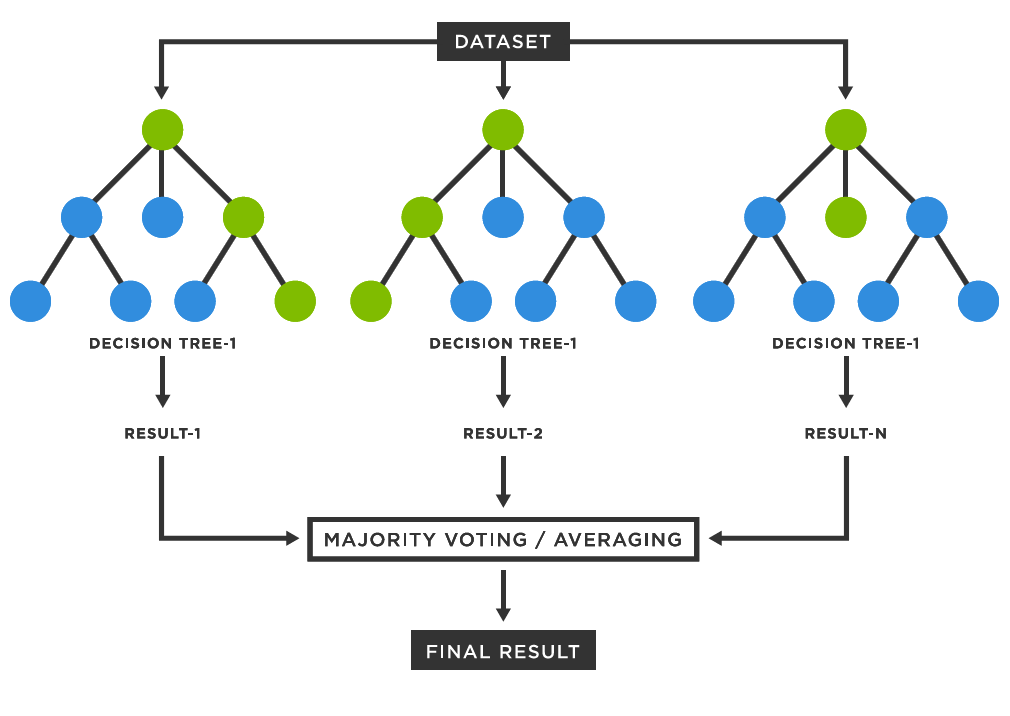

In [ ]:
rf_train_df, rf_test_df = train_test_split(match_df_num, test_size=0.2, random_state=42) #rf_test_df will later be used to test model accuracy on 
                                                                                        #different surfaces and tourney levels

X = rf_train_df.drop(columns=["winner"])
y = rf_train_df["winner"]

# instantiate model
rf_model = RandomForestClassifier()

# train the model 
rf_model.fit(X, y)

# test model using k-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=kfold)
accuracy = scores.mean()

print("Cross validation score: {}".format(accuracy))

Cross validation score: 0.6762371368135618


#### Now we can fine tune our model using Grid Search

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],         
    'max_depth': [None, 10, 20, 30],             
    'min_samples_split': [2, 5, 10],             
    'min_samples_leaf': [1, 2, 4],               
    'max_features': ['sqrt', 'log2', None]      
}

rf_model = RandomForestClassifier(random_state=18)

# Initialize the RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,cv=5, 
                                 verbose=2, random_state=42, n_jobs=-1, scoring="accuracy")

# Fit the model
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_accuracy))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30}
Test set accuracy: 0.68


### Creating Optimized Model and Graphing Most Important Features

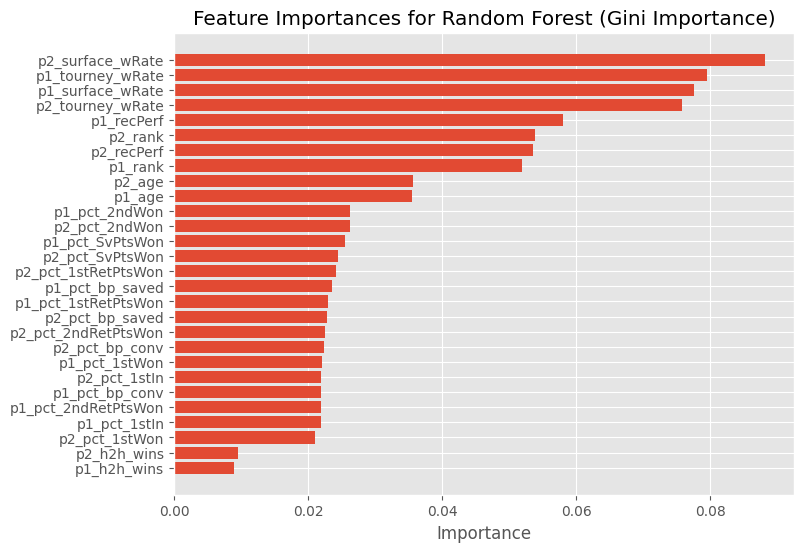

In [ ]:
X = rf_train_df[[
              #p1 stats
              'p1_age', 'p1_rank', 'p1_pct_1stIn', 'p1_pct_1stWon','p1_pct_2ndWon', 'p1_pct_SvPtsWon', 
              'p1_pct_bp_saved', 'p1_pct_bp_conv','p1_pct_1stRetPtsWon', 'p1_pct_2ndRetPtsWon', 
              'p1_surface_wRate', 'p1_recPerf', 'p1_tourney_wRate', 'p1_h2h_wins',
              #p2 stats
              'p2_age', 'p2_rank', 'p2_pct_1stIn','p2_pct_1stWon', 'p2_pct_2ndWon', 'p2_pct_SvPtsWon', 
              'p2_pct_bp_saved','p2_pct_bp_conv','p2_pct_1stRetPtsWon', 'p2_pct_2ndRetPtsWon', 
              'p2_surface_wRate','p2_recPerf', 'p2_tourney_wRate', 'p2_h2h_wins'
            ]]
y = rf_train_df["winner"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=300, min_samples_split=5, 
                                  min_samples_leaf=4, max_features="sqrt", max_depth=30)

rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances for Random Forest (Gini Importance)')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

## Using XGBoost (Extreme Gradient Boosting)

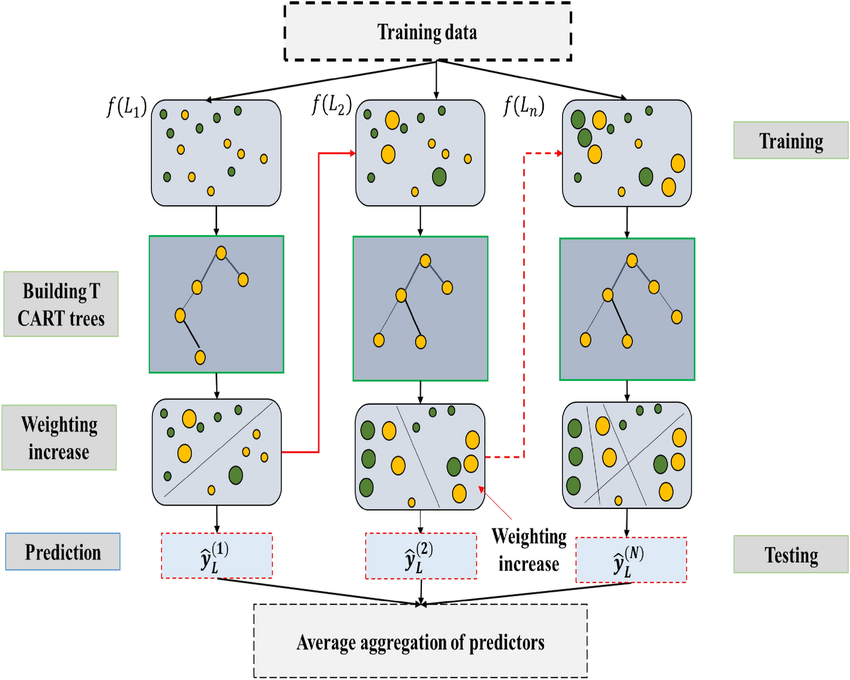]

##### from: https://www.researchgate.net/publication/370000558_Hybrid_machine_learning_approach_for_construction_cost_estimation_an_evaluation_of_extreme_gradient_boosting_model


In [ ]:
# making train test splits
xgb_train_df, xgb_test_df = train_test_split(match_df_num, test_size=0.3, random_state=9) #xgb_test_df will later be used to test model accuracy on 
                                                                                      #different surfaces and tourney levels

X = xgb_train_df.drop(columns=["winner"])
y = xgb_train_df["winner"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10)

from sklearn.metrics import accuracy_score

# Predict on test data
y_pred_prob = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


[0]	test-logloss:0.65593
[1]	test-logloss:0.63589
[2]	test-logloss:0.62285
[3]	test-logloss:0.61413
[4]	test-logloss:0.60885
[5]	test-logloss:0.60600
[6]	test-logloss:0.60411
[7]	test-logloss:0.60195
[8]	test-logloss:0.60157
[9]	test-logloss:0.60111
[10]	test-logloss:0.60056
[11]	test-logloss:0.60086
[12]	test-logloss:0.60085
[13]	test-logloss:0.60246
[14]	test-logloss:0.60279
[15]	test-logloss:0.60225
[16]	test-logloss:0.60254
[17]	test-logloss:0.60305
[18]	test-logloss:0.60357
[19]	test-logloss:0.60387
[20]	test-logloss:0.60405
Accuracy: 66.87%


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

# parameters for grid search to test
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 0.9,],
}

# Create an XGBoost classifier object
xgb_clf = xgb.XGBClassifier(eval_metric='logloss')

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Best parameters: {'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.8}
Accuracy: 67.95%


[0]	test-logloss:0.68174
[1]	test-logloss:0.67252
[2]	test-logloss:0.66397
[3]	test-logloss:0.65652
[4]	test-logloss:0.65038
[5]	test-logloss:0.64499
[6]	test-logloss:0.64084
[7]	test-logloss:0.63695
[8]	test-logloss:0.63307
[9]	test-logloss:0.62971
[10]	test-logloss:0.62701
[11]	test-logloss:0.62455
[12]	test-logloss:0.62237
[13]	test-logloss:0.62036
[14]	test-logloss:0.61848
[15]	test-logloss:0.61714
[16]	test-logloss:0.61559
[17]	test-logloss:0.61411
[18]	test-logloss:0.61288
[19]	test-logloss:0.61170
[20]	test-logloss:0.61062
[21]	test-logloss:0.60982
[22]	test-logloss:0.60877
[23]	test-logloss:0.60799
[24]	test-logloss:0.60722
[25]	test-logloss:0.60657
[26]	test-logloss:0.60594
[27]	test-logloss:0.60524
[28]	test-logloss:0.60475
[29]	test-logloss:0.60419
[30]	test-logloss:0.60357
[31]	test-logloss:0.60280
[32]	test-logloss:0.60225
[33]	test-logloss:0.60198
[34]	test-logloss:0.60164
[35]	test-logloss:0.60128
[36]	test-logloss:0.60097
[37]	test-logloss:0.60066
[38]	test-logloss:0.60

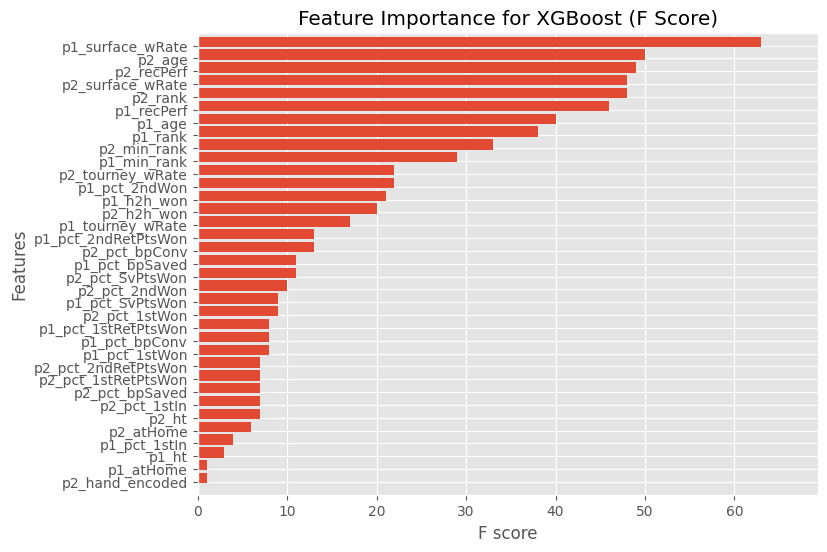

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'seed': 43
}

bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10)

# Predict on test data
y_pred_prob = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


# Plot feature importance
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 6))
xgb.plot_importance(bst, importance_type='weight', ax=ax)  # You can adjust 'importance_type' as needed

plt.title('Feature Importance for XGBoost (F Score)')

for text in ax.texts:
    text.set_visible(False)

for bar in ax.patches:
    bar.set_height(bar.get_height() * 4)  # Adjust the width as needed (e.g., 0.8 for 80% of original width)


plt.show()

## Using Logistic Regression

### Logistic regression performs very well when the dependent variable (in our case, the winner) has 1 of 2 values (0 or 1 in our case)

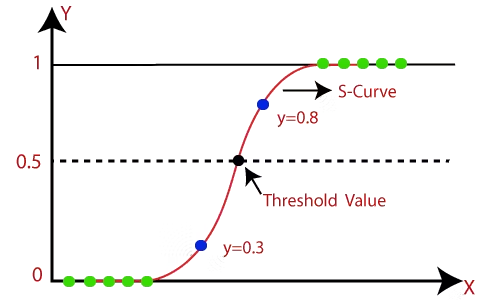

### Logistic Regression, being a *gradient based* algorithm, works better when training data is scaled/normalized

In [ ]:
features_to_scale = [
    'p1_age', 'p1_rank', 'p1_ht', 'p1_pct_1stIn', 'p1_pct_1stWon','p1_pct_2ndWon', 'p1_pct_SvPtsWon', 
    'p1_pct_bp_saved', 'p1_pct_bp_conv','p1_pct_1stRetPtsWon', 'p1_pct_2ndRetPtsWon', 
    'p1_surface_wRate', 'p1_recPerf', 'p1_tourney_wRate', 
    
    'p2_age', 'p2_rank', 'p2_ht', 'p2_pct_1stIn','p2_pct_1stWon','p2_pct_2ndWon', 'p2_pct_SvPtsWon', 
    'p2_pct_bp_saved','p2_pct_bp_conv','p2_pct_1stRetPtsWon', 'p2_pct_2ndRetPtsWon', 
    'p2_surface_wRate','p2_recPerf', 'p2_tourney_wRate'
]

scaler = MinMaxScaler()

match_df_lr = pd.DataFrame()

# Apply Min-Max scaling to the specified features
match_df_lr[features_to_scale] = scaler.fit_transform(match_df[features_to_scale])

match_df_lr = match_df_lr[features_to_scale]

#we still need winner column
match_df_lr["winner"] = match_df["winner"]

### Before we can start using logistic regression, it is good practice to find out which columns are actually necessary for predicting the winner. Failure to do this can lead to low performance because of how logistic regression models react to variables with high colinearity. We can do this using recursive feature elimination, and seeing which number of features optimizes the accuracy

##### Read more about RFE: https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html#:~:text=Recursive%20feature%20elimination%20(RFE)%20is,number%20of%20features%20is%20reached.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


highest_accuracy=0
num_max_features = match_df_num.drop(columns=["winner"]).shape[1]

for i in range(8, num_max_features+1): #we cant select more features than there are features

    #instantiate features and target
    X = match_df_num.drop(columns=["winner"])
    y = match_df["winner"]

    # create logistic regression model
    logistic_model = LogisticRegression(max_iter=1000)

    # create recursive feature eliminator
    rfe = RFE(estimator=logistic_model, n_features_to_select=i)
    rfe.fit(X,y)

    # use the selected features to filter X
    X_rfe = rfe.transform(X)

    # train the logistic regression model
    X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)
    logistic_model.fit(X_train, y_train)
    
    # Calculate the accuracy using k-fold cross validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(logistic_model, X_rfe, y, cv=kfold)
    accuracy = scores.mean()

    if accuracy > highest_accuracy:

        highest_accuracy = accuracy
        num_features_used = i
        selected_features = X.columns[rfe.support_]
        
print("Highest accuracy found: {}".format(highest_accuracy))
print("# of features used: {}".format(num_features_used))
print("Feature effectiveness ranked: {}".format(selected_features))

c:\Users\aurel\anaconda3\envs\AJPy\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\aurel\anaconda3\envs\AJPy\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

KeyboardInterrupt: 

### Now that we have the necessary features to most accurately predict a winner, it is time to optimize the hyperparamaters of the model using a Grid Search

In [ ]:
# using features chosen by last step
X = match_df_lr[[#p1 stats
              'p1_age', 'p1_rank', 'p1_ht', 'p1_pct_1stIn', 'p1_pct_1stWon','p1_pct_2ndWon', 'p1_pct_SvPtsWon', 
              'p1_pct_bp_saved', 'p1_pct_bp_conv','p1_pct_1stRetPtsWon', 'p1_pct_2ndRetPtsWon', 
              'p1_surface_wRate', 'p1_recPerf', 'p1_tourney_wRate', 
              #p2 stats
              'p2_age', 'p2_rank', 'p2_ht', 'p2_pct_1stIn','p2_pct_1stWon','p2_pct_2ndWon', 'p2_pct_SvPtsWon', 
              'p2_pct_bp_saved','p2_pct_bp_conv','p2_pct_1stRetPtsWon', 'p2_pct_2ndRetPtsWon', 
              'p2_surface_wRate','p2_recPerf', 'p2_tourney_wRate']]
y = match_df_lr["winner"]

#make train test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression(solver='liblinear')

#parameters to grid search
parameters = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2']        
}

grid_search = GridSearchCV(log_reg, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Use the best model to make predictions on the test set
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Best parameters found:  {'C': 100, 'penalty': 'l1'}
Best cross-validation accuracy: 71.03%
Test set accuracy: 71.09%


C:\Users\aurel\anaconda3\envs\AJPy\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Training the Final Logistic Regression Model

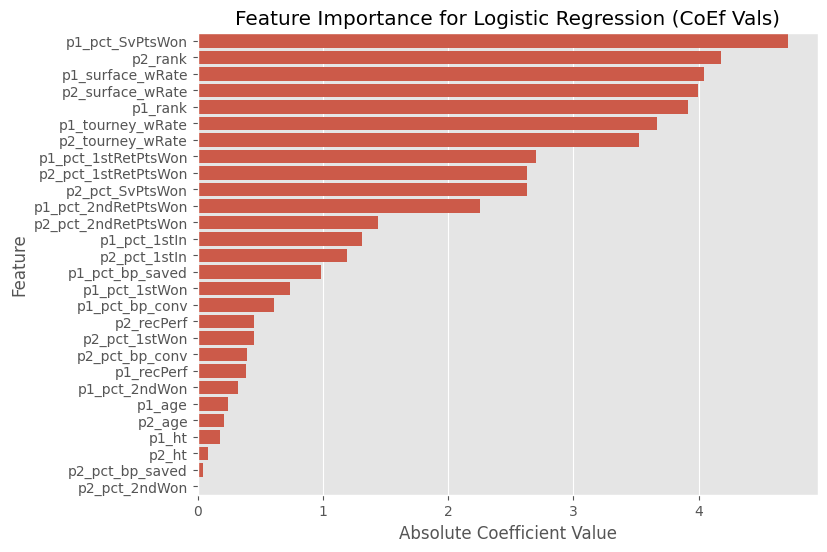

In [ ]:
lr_train_df, lr_test_df = train_test_split(match_df_lr, test_size=0.2, random_state=42) 

X = lr_train_df[[#p1 stats
              'p1_age', 'p1_rank', 'p1_ht', 'p1_pct_1stIn', 'p1_pct_1stWon','p1_pct_2ndWon', 'p1_pct_SvPtsWon', 
              'p1_pct_bp_saved', 'p1_pct_bp_conv','p1_pct_1stRetPtsWon', 'p1_pct_2ndRetPtsWon', 
              'p1_surface_wRate', 'p1_recPerf', 'p1_tourney_wRate', 
                #p2 stats
              'p2_age', 'p2_rank', 'p2_ht', 'p2_pct_1stIn','p2_pct_1stWon','p2_pct_2ndWon', 'p2_pct_SvPtsWon', 
              'p2_pct_bp_saved','p2_pct_bp_conv','p2_pct_1stRetPtsWon', 'p2_pct_2ndRetPtsWon', 
              'p2_surface_wRate','p2_recPerf', 'p2_tourney_wRate']]
y = lr_train_df["winner"]

# train using best parameters from grid search

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression(solver='liblinear', C=10, penalty="l1", max_iter=1000)

log_reg.fit(X_train, y_train)

feature_names = X_train.columns
coefficients = log_reg.coef_[0]

# create a DataFrame to use with plots
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# sort the DataFrame by absolute value of coefficients
feature_importance['abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance_sorted = feature_importance.sort_values(by='abs_Coefficient', ascending=False)

# plot the feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='abs_Coefficient', y='Feature', data=feature_importance_sorted)
plt.title('Feature Importance for Logistic Regression (CoEf Vals)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [ ]:
match_df.head()

surface tourney_level   p1_id             p1_name  p1_age       p1_ht  \
0    Clay             A  111456  Mackenzie Mcdonald    29.0  178.000000   
1    Clay             A  124116     Sebastian Ofner    28.0  191.000000   
2    Clay             A  210097         Ben Shelton    21.6  186.329197   
3    Clay             A  134770         Casper Ruud    25.4  183.000000   
4    Clay             A  202104      Sebastian Baez    23.3  170.000000   

   p1_rank  p1_hand_encoded  p1_pct_1stIn  p1_pct_1stWon  p1_pct_2ndWon  \
0     74.0                1         0.641          0.691          0.505   
1     45.0                1         0.567          0.732          0.485   
2     15.0                0         0.644          0.758          0.524   
3      7.0                1         0.646          0.724          0.542   
4     20.0                1         0.722          0.643          0.529   

   p1_pct_SvPtsWon  p1_pct_bp_saved  p1_pct_bp_conv  p1_pct_1stRetPtsWon  \
0            0.624            0.603           0.397                0.279   
1            0.625            0.614           0.402                0.284   
2            0.675            0.671           0.383                0.260   
3            0.660            0.635           0.408                0.280   
4            0.612            0.592           0.411                0.292   

   p1_pct_2ndRetPtsWon  p1_surface_wRate  p1_atHome  p1_recPerf  \
0                0.509             0.269          0    0.192769   
1                0.485             0.412          0    0.401692   
2                0.453             0.444          0    0.592909   
3                0.509             0.736          0    0.703052   
4                0.518             0.637          0    0.571134   

   p1_tourney_wRate  p1_h2h_wins   p2_id           p2_name  p2_age  \
0             0.475          0.0  126846  Aleksandar Vukic    28.1   
1             0.460          0.0  134770       Casper Ruud    25.4   
2             0.541          0.0  207925    Flavio Cobolli    22.0   
3             0.691          1.0  207830      Tomas Machac    23.6   
4             0.606          0.0  111576       Sumit Nagal    26.7   

        p2_ht  p2_rank  p2_hand_encoded  p2_pct_1stIn  p2_pct_1stWon  \
0  188.000000     93.0                1         0.595          0.730   
1  183.000000      7.0                1         0.646          0.724   
2  186.387134     56.0                1         0.572          0.695   
3  183.000000     44.0                1         0.632          0.699   
4  178.000000     94.0                1         0.700          0.609   

   p2_pct_2ndWon  p2_pct_SvPtsWon  p2_pct_bp_saved  p2_pct_bp_conv  \
0          0.513            0.642            0.593           0.351   
1          0.542            0.660            0.635           0.408   
2          0.490            0.607            0.629           0.410   
3          0.511            0.630            0.642           0.397   
4          0.550            0.591            0.587           0.392   

   p2_pct_1stRetPtsWon  p2_pct_2ndRetPtsWon  p2_surface_wRate  p2_atHome  \
0                0.265                0.460             0.364          0   
1                0.280                0.509             0.736          0   
2                0.329                0.485             0.500          0   
3                0.275                0.512             0.667          0   
4                0.233                0.499             0.333          0   

   p2_recPerf  p2_tourney_wRate  p2_h2h_wins  winner  
0    0.341502             0.415          0.0       0  
1    0.703052             0.691          1.0       0  
2    0.471189             0.519          0.0       0  
3    0.526883             0.500          0.0       1  
4    0.315016             0.214          0.0       1

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class TennisModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.ff_layer1 = nn.Linear(in_features=36, out_features=64)
        self.ff_layer2 = nn.Linear(in_features=64, out_features=32)
        self.ff_layer3 = nn.Linear(in_features=32, out_features=1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        # no sigmoid needed since we will use BCEWithLogitsLoss

    def forward(self, X):
        return self.ff_layer3(
                    self.leaky_relu(
                        self.ff_layer2(
                            self.ff_layer1(X))))
    
model = TennisModel()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(params=model.parameters(), lr=0.05)

X = torch.tensor(
    np.array(
        match_df_num.drop(columns=["winner"])
)).to(device=device)

y = torch.tensor(match_df_num["winner"].values).to(device=device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=87)
X_train = X_train.to(device, dtype=torch.float32)
X_test = X_test.to(device, dtype=torch.float32)
y_train = y_train.to(device, dtype=torch.float32)
y_test = y_test.to(device, dtype=torch.float32)

epochs = 10000
for epoch in range(epochs):

    model.train() # put model in train mode

    y_preds = model(X_train).to(dtype=torch.float32)

    loss = loss_fn(y_preds.squeeze(), y_train) # get BCEWithLogitsLoss

    optimizer.zero_grad() # reset gradients to zero
    loss.backward()
    optimizer.step()

    if epoch%1000 == 0:

        model.eval() # turns off some settings not needed
        with torch.inference_mode(): # turns off gradient tracking and other things
    
            # do forward pass
            test_logits = model(X_test).to(dtype=torch.float32)
            test_loss = loss_fn(test_logits.squeeze(), y_test)

            test_probs = torch.sigmoid(test_logits.squeeze())  # Use sigmoid
            y_preds = (test_probs > 0.5).int()  # Convert to 0 or 1
            
            accuracy = accuracy_score(y_test, y_preds)
    
        print(f"Epoch: {epoch}, Train Loss: {loss} | Test Loss: {test_loss} Test Accuracy: {accuracy}")


    





Epoch: 0, Train Loss: 1.2115448713302612 | Test Loss: 93.70570373535156 Test Accuracy: 0.5068009552486762
Epoch: 1000, Train Loss: 0.6095690131187439 | Test Loss: 0.6150301098823547 Test Accuracy: 0.6627556847679369
Epoch: 2000, Train Loss: 0.5948489308357239 | Test Loss: 0.6030452847480774 Test Accuracy: 0.6688817360606375
Epoch: 3000, Train Loss: 0.5956855416297913 | Test Loss: 0.6060284972190857 Test Accuracy: 0.6653514692139965
Epoch: 4000, Train Loss: 0.5967186689376831 | Test Loss: 0.6073663830757141 Test Accuracy: 0.6642093240577303
Epoch: 5000, Train Loss: 0.5993558764457703 | Test Loss: 0.6054953932762146 Test Accuracy: 0.6629633475236216
Epoch: 6000, Train Loss: 0.6143639087677002 | Test Loss: 0.6235871315002441 Test Accuracy: 0.6605752258332468
Epoch: 7000, Train Loss: 0.6142284274101257 | Test Loss: 0.6274159550666809 Test Accuracy: 0.6570449589866058
Epoch: 8000, Train Loss: 0.6144634485244751 | Test Loss: 0.6341150999069214 Test Accuracy: 0.6569411276087633
Epoch: 9000, T

In [ ]:
test_logits[1]

tensor([20.0711])

## Model Analysis and Breakdown

### I know how these models perform overall, but how do they perform across different playing surfaces or across different tournament levels. Is one model more likely to predict upsets on certain surfaces or in certain tournament levels?

In [ ]:
def get_acc_score_for_xgb(model, X, y): #calculates accuracy score for an xgboost model
    
    dtest = xgb.DMatrix(X, label=y)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

    accuracy = accuracy_score(y, y_pred)

    return accuracy
    

def evaluate_model_on_surfaces(model, test_df, category):

    if category == "surface":
    
        groups = ["Grass", "Hard", "Clay"]

    elif category == "tourney_level":

        groups = ["G", "M", "A", "F", "O"]

    group_accuracies = [] #will hold dictionaries for each group with attributes being overall accuracy and upset accuracy

    for group in groups:
        
        accuracies = {} 

        features = [#p1 stats
                   'p1_age', 'p1_rank', 'p1_ht', 'p1_pct_1stIn', 'p1_pct_1stWon','p1_pct_2ndWon', 'p1_pct_SvPtsWon', 
                   'p1_pct_bp_saved', 'p1_pct_bp_conv','p1_pct_1stRetPtsWon', 'p1_pct_2ndRetPtsWon', 
                   'p1_surface_wRate', 'p1_recPerf', 'p1_tourney_wRate', 
                    #p2 stats
                   'p2_age', 'p2_rank', 'p2_ht', 'p2_pct_1stIn','p2_pct_1stWon', 'p2_pct_2ndWon', 'p2_pct_SvPtsWon', 
                   'p2_pct_bp_saved','p2_pct_bp_conv','p2_pct_1stRetPtsWon', 'p2_pct_2ndRetPtsWon', 
                   'p2_surface_wRate','p2_recPerf', 'p2_tourney_wRate']
        target = "winner"

        # Filter test data for the current surface
        group_games = test_df[test_df[category] == group]

        #finds upset matches on specified surface
        group_upsets = test_df[
            (test_df[category] == group) & 
            (
                ((test_df["p1_rank"] < test_df["p2_rank"]) & (test_df["winner"] == 0)) ^ 
                ((test_df["p1_rank"] > test_df["p2_rank"]) & (test_df["winner"] == 1))
            )
        ]

        X = group_games[features]
        y = group_games[target]

        if type(model) == xgb.core.Booster: #XGBoost model follows different method for computing accuracy

            accuracy = get_acc_score_for_xgb(model, X, y)

        else: #for random forest and log reg

            y_pred = model.predict(X)
            accuracy = accuracy_score(y, y_pred)

        X_upsets = group_upsets[features]
        y_upsets = group_upsets[target]

        if type(model) == xgb.core.Booster:

            upset_accuracy = get_acc_score_for_xgb(model, X_upsets, y_upsets)

        else:
            y_upset_pred = model.predict(X_upsets)
            upset_accuracy = accuracy_score(y_upsets, y_upset_pred)
    
        accuracies[category] = group 
        accuracies["Overall Accuracy"] = round(accuracy, 2)
        accuracies["Upset Accuracy"] = round(upset_accuracy, 2)

        group_accuracies.append(accuracies)

    return pd.DataFrame(group_accuracies).set_index(category)

#### Defining function to plot the overall accuracies and upset accuracies of the threee models across different surfaces and different tournament levels (eg. Grand Slam, ATP 250, etc)

In [ ]:
def plot_groups(category):

    models = ['Logistic Regression', 'Random Forest', 'XGBoost']

    dfs = [
        evaluate_model_on_surfaces(log_reg, lr_test_df, category), 
        evaluate_model_on_surfaces(rf_model, rf_test_df, category),
        evaluate_model_on_surfaces(bst, xgb_test_df, category)
    ]
    
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Define bar width and positions
    bar_width = 0.35
    index = np.arange(len(lr_df.index))

    plt.suptitle(f'Accuracy on {" ".join(category.split("_")).title()} Categories by Model', fontsize=16) # title of entire graph
    
    for ax, df, model in zip(axes, dfs, models):
        index = np.arange(len(df.index))
        overall = df['Overall Accuracy']
        upset = df['Upset Accuracy']
        
        # Plotting bars
        ax.bar(index, overall, bar_width, label='Overall Accuracy', color="#192841")
        ax.bar(index + bar_width, upset, bar_width, label='Upset Accuracy', color="#0287c3")
        
        # Labels, title, and formatting
        ax.set_xlabel(category)
        ax.set_ylabel('Accuracy')
        ax.set_title(model)
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(df.index)
        ax.legend()
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

### As we can see by the graphs, it appears that **grass** is the best surface for our 3 models to predict upsets on followed by clay and then hard court. 

### The logistic regression model appears to be great at predicting Olympic matches, with a high upset accuracy as well. It appears that **Grand Slam matches and Olympic matches** seem to be the easiest to accurately predict for our 3 models.

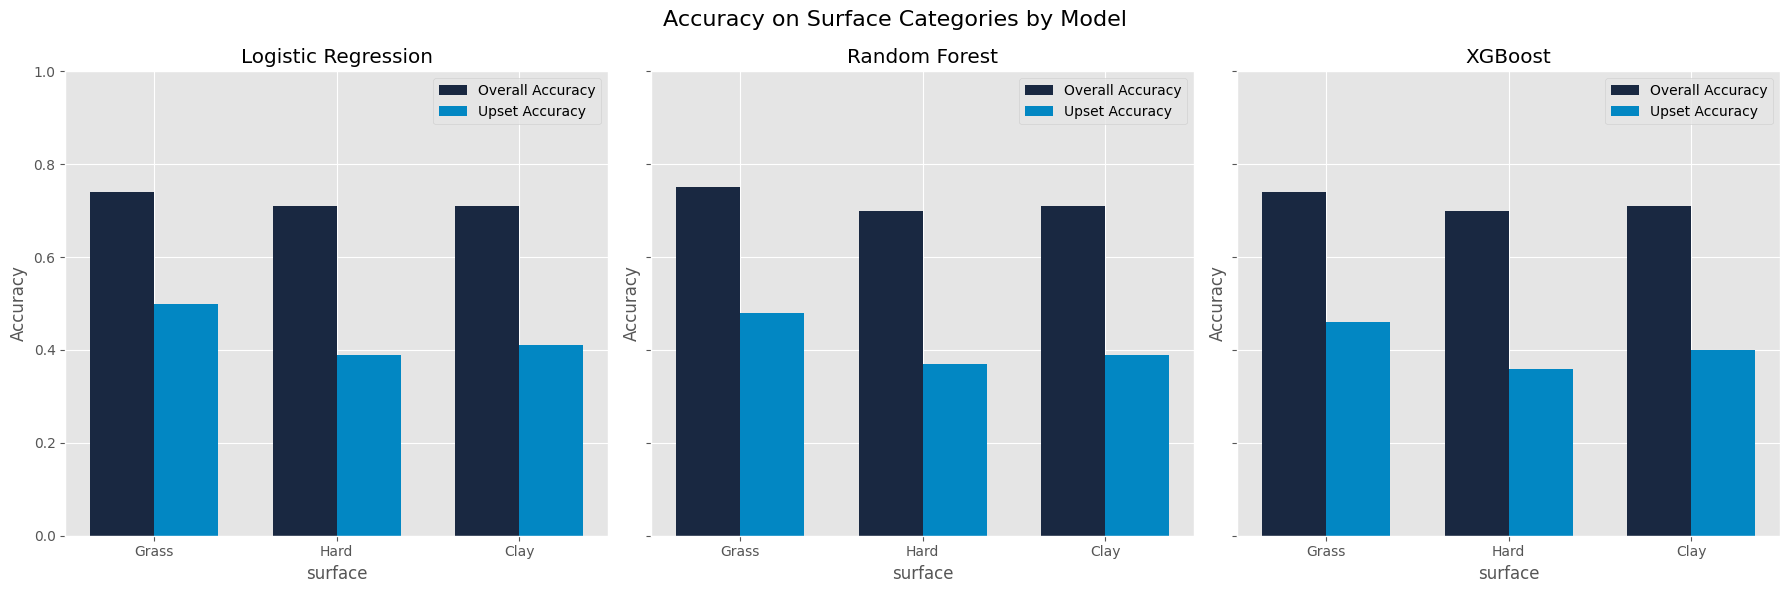

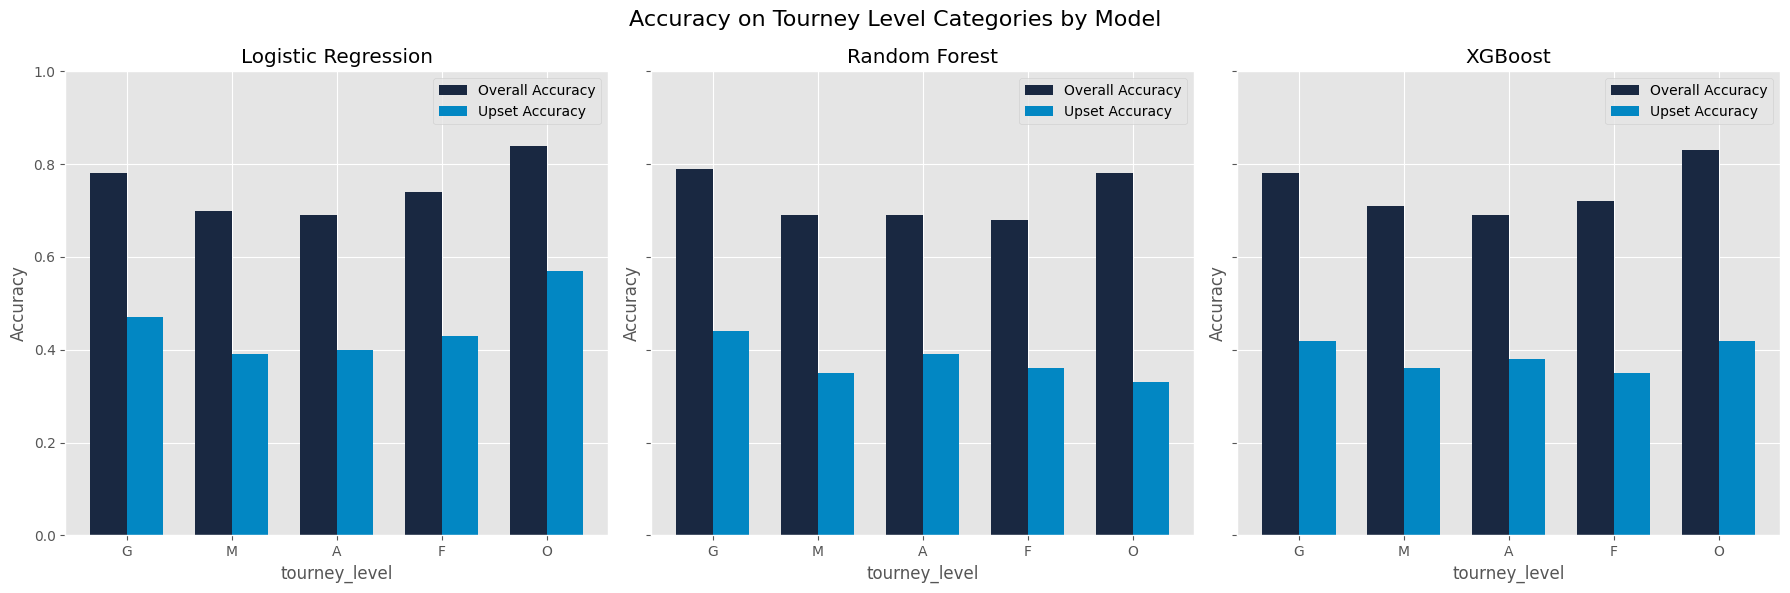

In [ ]:
plot_groups("surface")
print("\n")
plot_groups("tourney_level")

## Saving Files to Use for Dash Application

In [ ]:
stats_df.to_csv("PlayerStats.csv", index=False)
match_df.to_csv("ATPMatches.csv", index=False)
players.to_csv("players.csv", index=False)